# Settings

In this notebook we work with the problem of multi-class classification, that is, the correct assignment of an object to one of the classes. Our goal is to achieve high accuracy of assignment to the correct category. We will use the widely used transfer learning method.


Transfer learning is a machine learning technique that uses a pre-trained model. In this approach, a model trained on one data is used or retrained for use with another set of data. By using transfer learning, you can achieve significantly higher classification accuracy, especially when the available data set is limited.

Before running the code, we need to make sure that we are using the GPU. We plan to work with a convolutional neural network, and using a GPU allows us to reduce training time by several times.

In [1]:
# display information about available GPU devices
!nvidia-smi

Mon Jun  9 00:33:39 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   44C    P8             10W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Import libraries

In [2]:
# Visualization purpose
!pip install tensorboardX
!pip install tensorboard
!pip install tensorboard-plugin-customizable-plots

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 19.1 MB/s eta 0:00:00


In [3]:
!pip install split-folders
!pip install optuna
!pip install codecarbon

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 610.1/610.1 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 kB 7.2 MB/s eta 0:00:00
  Attempting uninstall: termcolor
    Found existing installation: termcolor 3.0.1
    Uninstalling termcolor-3.0.1:
      Successfully uninstalled termcolor-3.0.1
  Attempting uninstall: httpx
    Found existing installation: httpx 0.28.1
    Uninstalling httpx-0.28.1:
      Successfully uninstalled httpx-0.28.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-genai 1.9.0 requires httpx<1.0.0,>=0.28.1, but you have httpx 0.27.2 which is incompatible.


In [4]:
import os
import shutil
import splitfolders
from pathlib import Path
import imghdr
import numpy as np
from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt 
import random
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from codecarbon import EmissionsTracker

/tmp/ipykernel_19/4273075705.py:5: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr
2025-06-09 00:34:26.891389: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749429267.084509      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749429267.140884      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
import warnings
warnings.filterwarnings('ignore')

# Description of the data set

The dataset contains approximately 12,000 images divided into seven categories of waste, including paper, metal, cardboard, trash, glass, biological, and plastic.


# Data Preprcessing

In [6]:
prepare_data_emission_tracker = EmissionsTracker()
prepare_data_emission_tracker.start()

[codecarbon WARNING @ 00:34:38] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 00:34:38] [setup] RAM Tracking...
[codecarbon INFO @ 00:34:38] [setup] CPU Tracking...
[codecarbon WARNING @ 00:34:39] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 00:34:39] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 00:34:39] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon WARNING @ 00:34:39] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 00:34:39] [setup] GPU Tracking...
[codecarbon INFO @ 00:34:39] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 00:34:39] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation mode

In [7]:
data_dir = '/kaggle/input/dwaste-data-v4'

Cleaning the working directory if there are any files in it

In [8]:
def remove_folder_contents(folder):
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                remove_folder_contents(file_path)
                os.rmdir(file_path)
        except Exception as e:
            print(e)

folder_path = '/kaggle/working'
remove_folder_contents(folder_path)
# os.rmdir(folder_path)

Copying the dataset to the working directory to allow data cleaning

In [9]:
shutil.copytree(data_dir, '/kaggle/working/dataset')

[codecarbon INFO @ 00:34:58] Energy consumed for RAM : 0.000083 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:34:58] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:34:58] Energy consumed for All CPU : 0.000177 kWh
[codecarbon INFO @ 00:34:58] Energy consumed for all GPUs : 0.000087 kWh. Total GPU Power : 20.776997648493882 W
[codecarbon INFO @ 00:34:58] 0.000347 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:35:13] Energy consumed for RAM : 0.000167 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:35:13] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:35:13] Energy consumed for All CPU : 0.000354 kWh
[codecarbon INFO @ 00:35:13] Energy consumed for all GPUs : 0.000172 kWh. Total GPU Power : 20.61697644212481 W
[codecarbon INFO @ 00:35:13] 0.000693 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:35:28] Energy consumed for RAM : 0.000250 kWh. RAM Power : 

'/kaggle/working/dataset'

In [10]:
data_dir  = '/kaggle/working/dataset'

In [11]:
experiment_name = "Transfer Learning"

The Tensorflow library that we are going to use does not support some image formats, in addition, the dataset may have corrupted or non-image files. Let's pre-clean the dataset.

In [12]:
count=0
image_extensions = [".png", ".jpg"] 
img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]

for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        if img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            os.remove(filepath)
            count+=1
print(f"Removed {count} images")

/kaggle/working/dataset/paper/paper_1678.jpg is a webp, not accepted by TensorFlow
/kaggle/working/dataset/paper/paper_3119.jpg is a webp, not accepted by TensorFlow
/kaggle/working/dataset/paper/paper_2784.jpg is a webp, not accepted by TensorFlow
/kaggle/working/dataset/paper/paper_2184.jpg is not an image
/kaggle/working/dataset/paper/paper_2184.jpg is a None, not accepted by TensorFlow
/kaggle/working/dataset/paper/paper_1433.jpg is not an image
/kaggle/working/dataset/paper/paper_1433.jpg is a None, not accepted by TensorFlow
/kaggle/working/dataset/paper/paper_2779.jpg is not an image
/kaggle/working/dataset/paper/paper_2779.jpg is a None, not accepted by TensorFlow
/kaggle/working/dataset/cardboard/cardboard_2088.jpg is not an image
/kaggle/working/dataset/cardboard/cardboard_2088.jpg is a None, not accepted by TensorFlow
/kaggle/working/dataset/cardboard/cardboard_313.jpg is not an image
/kaggle/working/dataset/cardboard/cardboard_313.jpg is a None, not accepted by TensorFlow
/

To train the model, you will need to divide the data into several samples, so we will create folders for them

In [13]:
os.mkdir('data')

In [14]:
os.chdir('data')

In [15]:
os.getcwd()

'/kaggle/working/data'

In [16]:
os.mkdir('train')
os.mkdir('test')
os.mkdir('val')

In [17]:
os.chdir('/kaggle/working/')

In [18]:
os.getcwd()

'/kaggle/working'

Let's set a random value for reproducibility of the result. In particular, when splitting the dataset randomly (as in the following block of code), a fixed SEED value ensures that we get exactly the same split of data next time.

In [19]:
SEED = 42

Let's divide the data from the dataset into three folders - for training and test samples.

In [20]:
splitfolders.ratio("/kaggle/working/dataset", output = 'data', seed = SEED, ratio = (.8,.1,.1), group_prefix = None)

Copying files: 2092 files [00:00, 6234.07 files/s][codecarbon INFO @ 00:35:43] Energy consumed for RAM : 0.000333 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:35:43] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:35:43] Energy consumed for All CPU : 0.000708 kWh
[codecarbon INFO @ 00:35:43] Energy consumed for all GPUs : 0.000343 kWh. Total GPU Power : 20.491549429789146 W
[codecarbon INFO @ 00:35:43] 0.001385 kWh of electricity used since the beginning.
Copying files: 11151 files [00:01, 6134.94 files/s]


In [21]:
data_dir

'/kaggle/working/dataset'

You can now delete the unused dataset folder to save space.

In [22]:
try:
    shutil.rmtree(data_dir)
except OSError as e:
    print("Error: %s : %s" % (data_dir, e.strerror))

Setting paths to training and test data

In [23]:
train_path = '/kaggle/working/data/train'
val_path = '/kaggle/working/data/val'
test_path = '/kaggle/working/data/test'

Visualization of data from a dataset

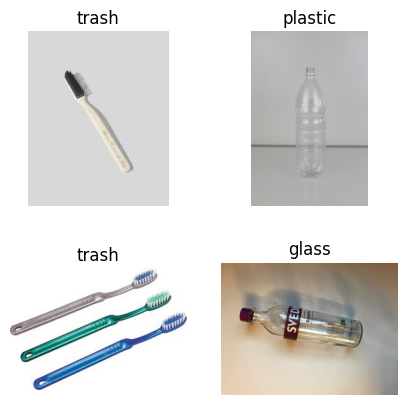

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(5, 5))  # Display 4 images
axes = axes.ravel()

for i in np.arange(0, 4):
    category = random.choice(os.listdir(train_path))  # Randomly choose a class
    class_dir = os.path.join(train_path, category)

    image = random.choice(os.listdir(class_dir))  # Randomly choose an image from that class

    img = plt.imread(os.path.join(class_dir, image))
    axes[i].imshow(img)
    axes[i].set_title(category)
    axes[i].axis('off')


Let's look at the distribution of data between classes.

In [25]:
total = 0
for category in os.listdir(train_path):
    count= 0
    for image in os.listdir(train_path + "/" + category):
        count += 1
        total +=1
    print(str(category).title() + ": " + str(count))  
print(f"\nTotal number of train images: {total}")

Metal: 795
Paper: 1315
Trash: 617
Biological: 786
Glass: 2431
Cardboard: 1446
Plastic: 1528

Total number of train images: 8918


It is noticeable that in some classes the number of images differs several times. Let's visualize the distribution of classes for clarity.

In [26]:
# class names
class_names = sorted(os.listdir(train_path))
class_names

['biological', 'cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [27]:
class_dis = [len(os.listdir(train_path + f"/{name}")) for name in class_names]
class_dis

[786, 1446, 2431, 795, 1315, 1528, 617]

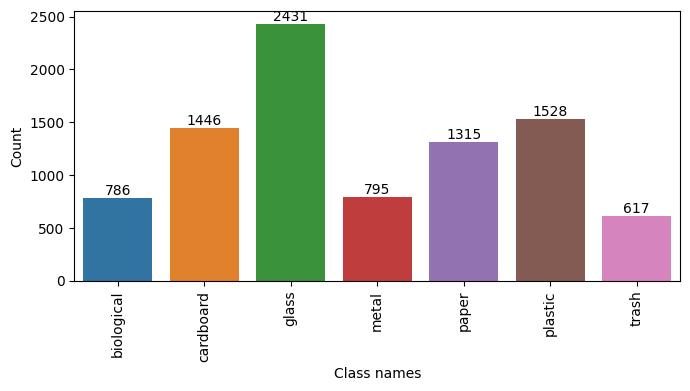

In [28]:
DF = pd.DataFrame(columns=['Class names','Count'])
DF['Class names']=class_names
DF['Count']=class_dis
plt.figure(figsize=(7,4))
ax=sns.barplot(x='Class names', y='Count', data=DF)
ax.bar_label(ax.containers[0])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tight_layout()

### Class Imbalance in the Dataset

A situation where one or more classes contain a significantly larger number of images is known as **class imbalance**. In our case, this imbalance is expected and reflects the nature of real-world waste distribution. For example:

- **Glass**: 3,039 images  
- **Plastic**: 1,915 images  
- **Cardboard**: 1,810 images  
- **Paper**: 1,650 images  
- **Metal**: 994 images  
- **Biological**: 983 images  
- **Trash**: 772 images  

This imbalance can negatively affect the model’s performance, leading it to favor the larger classes and perform poorly on the underrepresented ones.

To address this issue, we will apply **random undersampling**, a technique that balances the dataset by randomly removing some examples from the overrepresented classes. This helps reduce model bias and improves its ability to generalize across all categories.


Excluding some random images from the training data

In [29]:
for category in os.listdir(train_path):
    count = 0
    delete = 0
    for image in os.listdir(train_path + '/'  + category):
        count += 1
        while count > 1000:
            random_image = random.choice(os.listdir(train_path + '/' + category)) 
            delete_image = train_path + '/'  + category +  '/' + random_image
            os.remove(delete_image)
            delete+=1
            count-=1
           
    print(f'Deleted {delete} in {category}')


Deleted 0 in metal
Deleted 315 in paper
Deleted 0 in trash
Deleted 0 in biological
Deleted 1431 in glass
Deleted 446 in cardboard
Deleted 528 in plastic


We limited the number of images in large classes to 1000. Let's see what the class distribution looks like now

In [30]:
class_dis = [len(os.listdir(train_path + f"/{name}")) for name in class_names]

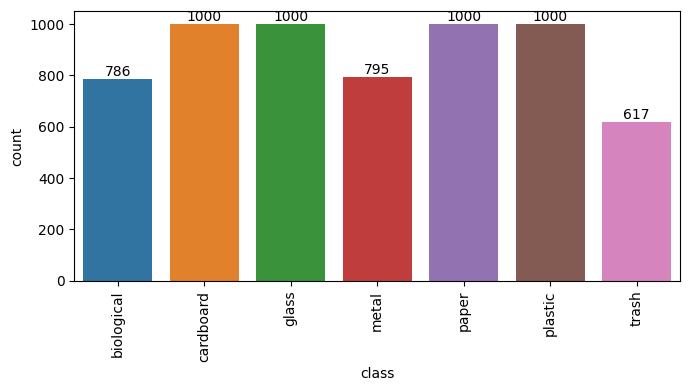

In [31]:
DF = pd.DataFrame(columns=['class','count'])
DF['class']=class_names
DF['count']=class_dis
plt.figure(figsize=(7,4))
ax=sns.barplot(x='class', y='count', data=DF)
ax.bar_label(ax.containers[0])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tight_layout()

The data distribution now looks much better, although some image classes are still quite sparse. We will try to solve this problem using augmentation methods that we integrate into the model.

In [32]:
data_path = '/kaggle/working/data'

To train a neural network, it is necessary to ensure unification of image sizes. To do this, let’s find the average width and height of images in the entire dataset.

In [33]:
width = []
height = []
from PIL import Image
import numpy as np

for dirname in os.listdir(data_path):
    for category in os.listdir(data_path + '/' + dirname):
        for image in os.listdir(data_path + '/' + dirname + '/' + category):
            img = Image.open(data_path + '/' + dirname + '/' + category + '/' + image)
            width.append(img.width)
            height.append(img.height)

print('Mean width: {:.4f}'.format(np.mean(width)))
print('Mean Height: {:.4f}'.format(np.mean(height)))

Mean width: 442.2982
Mean Height: 416.3913


Let's set the size of the input data (image size) taking into account the found average values

In [34]:
IMG_SIZE = (400, 400)

Let's set the size of the data package for loading images into the model in parts

In [35]:
BATCH_SIZE = 32


Create a SummaryWriter instance to write logs

In [36]:
writer = SummaryWriter()

Previously, we divided the entire amount of data into three sets. Now you need to prepare them for working with the model - distribute them into packages and add labels to them. Data packets generated from the train folder, constituting 80% of the total number of images, will be used to train the model, from the val(10%) folder - for checking during training and adjusting parameters, and from the test folder - to evaluate the accuracy of the model on new data not used during training.


In [37]:
train_data = tf.keras.utils.image_dataset_from_directory(train_path,
                                                         image_size=IMG_SIZE,
                                                         label_mode='categorical',
                                                         batch_size=BATCH_SIZE,
                                                         shuffle=True,
                                                         seed=SEED)

Found 6198 files belonging to 7 classes.


I0000 00:00:1749429350.301539      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749429350.302359      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [38]:
test_data = tf.keras.utils.image_dataset_from_directory(test_path,
                                                        image_size=IMG_SIZE,
                                                        label_mode='categorical',
                                                        batch_size=BATCH_SIZE,
                                                        shuffle=False)

Found 1121 files belonging to 7 classes.


In [39]:
validation_data = tf.keras.utils.image_dataset_from_directory(val_path,
                                                              image_size=IMG_SIZE,
                                                              label_mode='categorical',
                                                              batch_size=BATCH_SIZE,
                                                              shuffle=True,
                                                              seed=SEED)

Found 1112 files belonging to 7 classes.


Create directories for train and test logs and write logs to it 

In [40]:
train_log_dir = os.path.join("logs", experiment_name, "train")
test_log_dir = os.path.join("logs", experiment_name, "test")

os.makedirs(train_log_dir, exist_ok=True)
os.makedirs(test_log_dir, exist_ok=True)

train_writer = SummaryWriter(train_log_dir)
test_writer = SummaryWriter(test_log_dir)


In [41]:
prepare_data_emissions: float = prepare_data_emission_tracker.stop()
print(f"Prepare Data Carbon Emissions: {prepare_data_emissions} kg")

[codecarbon INFO @ 00:35:52] Energy consumed for RAM : 0.000385 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:35:52] Delta energy consumed for CPU with constant : 0.000110 kWh, power : 42.5 W
[codecarbon INFO @ 00:35:52] Energy consumed for All CPU : 0.000818 kWh
[codecarbon INFO @ 00:35:52] Energy consumed for all GPUs : 0.000417 kWh. Total GPU Power : 28.606216295119705 W
[codecarbon INFO @ 00:35:52] 0.001620 kWh of electricity used since the beginning.


Prepare Data Carbon Emissions: 0.00022483485316364597 kg


# Building the model

When selecting a model, we examined the classification models available in Keras with pre-trained weights on the public ImageNet dataset, which includes about 1000 categories of various images (https://keras.io/api/applications/).
For our task, the most important parameter is the classification accuracy. Based on the accuracy values presented in the table (acc1, percentage of correct answers), the EfficientNetV2S model, which has 88 layers, was selected. Although the EfficientNetV2M and EfficientNetV2L models have higher accuracy, they have significantly higher weights.


In [42]:
develop_model_emission_tracker = EmissionsTracker()
develop_model_emission_tracker.start()

[codecarbon WARNING @ 00:35:52] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 00:35:52] [setup] RAM Tracking...
[codecarbon INFO @ 00:35:52] [setup] CPU Tracking...
[codecarbon WARNING @ 00:35:53] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 00:35:53] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 00:35:53] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon WARNING @ 00:35:53] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 00:35:53] [setup] GPU Tracking...
[codecarbon INFO @ 00:35:53] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 00:35:53] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation mode

Loading the model

In [43]:
base_model = tf.keras.applications.EfficientNetV2S(include_top=False,
                                                   weights='imagenet', 
                                                   input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Let's see what the architecture of the pretrained model looks like

In [44]:
base_model.summary()

Model: "efficientnetv2-s"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 400, 400, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 400, 400, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 200, 200, 24)   │            648 │ rescaling[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 200, 200, 24)   │             96 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 200, 200, 24)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_conv      │ (None, 200, 200, 24)   │          5,184 │ stem_activation[0][0]  │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_bn        │ (None, 200, 200, 24)   │             96 │ block1a_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_activati… │ (None, 200, 200, 24)   │              0 │ block1a_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_add (Add)         │ (None, 200, 200, 24)   │              0 │ block1a_project_activ… │
│                           │                        │                │ stem_activation[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_conv      │ (None, 200, 200, 24)   │          5,184 │ block1a_add[0][0]      │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_bn        │ (None, 200, 200, 24)   │             96 │ block1b_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_activati… │ (None, 200, 200, 24)   │              0 │ block1b_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_drop (Dropout)    │ (None, 200, 200, 24)   │              0 │ block1b_project_activ… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_add (Add)         │ (None, 200, 200, 24)   │              0 │ block1b_drop[0][0],    │
│                           │                        │                │ block1a_add[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_expand_conv  

 Total params: 20,331,360 (77.56 MB)

 Trainable params: 20,177,488 (76.97 MB)

 Non-trainable params: 153,872 (601.06 KB)

The architecture of the model we are using already has a Rescale layer, so we may not include an additional image normalization layer in our model.ь.

Let's freeze all layers of the pretrained model so that its parameters do not change during training.

In [45]:
base_model.trainable = False

Let's create a data augmentation layer to improve classification accuracy. This layer is active only during model training.

In [46]:
data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip("horizontal"),
                                         tf.keras.layers.RandomRotation(0.2), 
                                         tf.keras.layers.RandomZoom(0.2),
                                         tf.keras.layers.RandomHeight(0.2),
                                         tf.keras.layers.RandomWidth(0.2),],
                                         name ="data_augmentation")

Let's see how this layer works with images from the training set.

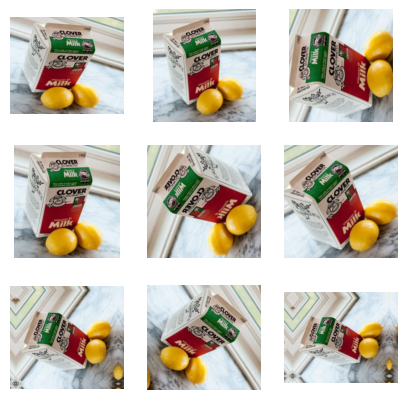

In [47]:
for image, _ in train_data.take(1):  
    plt.figure(figsize=(5, 5))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

Let's combine the model with the augmentation layer, and also add several layers:

* GlobalAveragePooling2D layer, which calculates the arithmetic average over all channels to combine feature maps
* A fully connected layer with 128 neurons and a Dropout layer, which excludes some neurons from the previous fully connected layer with a given probability, thereby reducing the possible effect of overfitting.
* Output fully connected layer with the number of outputs corresponding to the number of classes of our data.

In [48]:
name="EfficientNetV2S"

EfficientNetV2S_model=tf.keras.Sequential([tf.keras.Input(shape=(None, None, 3), name="input_layer"),
                    data_augmentation,
                    base_model,
                    tf.keras.layers.GlobalAveragePooling2D(),
                    tf.keras.layers.Dense(128, activation='relu'),
                    tf.keras.layers.Dropout(0.2),
                    tf.keras.layers.Dense(len(class_names), activation='softmax')
                    ], name=name)

For training, we will define a loss function, an optimizer, and a tracked accuracy metric

In [49]:
EfficientNetV2S_model.compile(loss='categorical_crossentropy',
                              optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
                              metrics=['accuracy'])

Let's look at the structure of our model

In [50]:
EfficientNetV2S_model.summary()

Model: "EfficientNetV2S"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)       │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-s (Functional)        │ (None, None, None, 1280)    │      20,331,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,496,231 (78.19 MB)

 Trainable params: 164,871 (644.03 KB)

 Non-trainable params: 20,331,360 (77.56 MB)

The summary already shows the advantage of using a pre-trained model - out of more than 20 million parameters, only 165 thousand are trainable, which will significantly reduce training time.

While training the models, we will use a callback function to stop training when the metrics being tracked stop improving. After this, we will save the trained model and weights for further use.

In [51]:
# def log_to_tensorboard(epoch, logs):
#         train_writer.add_scalar('loss', logs['loss'], epoch)
#         train_writer.add_scalar('accuracy', logs['accuracy'], epoch)
#         test_writer.add_scalar('val_loss', logs['val_loss'], epoch)
#         test_writer.add_scalar('val_accuracy', logs['val_accuracy'], epoch)
def log_to_tensorboard(epoch, logs):
    train_writer.add_scalar('loss', logs['loss'], epoch)
    train_writer.add_scalar('accuracy', logs['accuracy'], epoch)
    
    # Use get method with a default value of None to avoid KeyError
    val_loss = logs.get('val_loss', None)
    val_accuracy = logs.get('val_accuracy', None)
    
    if val_loss is not None:
        test_writer.add_scalar('val_loss', val_loss, epoch)
    if val_accuracy is not None:
        test_writer.add_scalar('val_accuracy', val_accuracy, epoch)


# Creating a Callback Function
def create_callback(model_name):
    
    # termination of training when accuracy does not improve within 3 epochs
    early_stop = tf.keras.callbacks.EarlyStopping(patience=3,
                                                monitor="val_loss",
                                                mode="min",
                                                verbose=1)

    # decrease in learning rate when the error rate does not decrease over 2 epochs
    reduce_learning_rate = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                              factor=0.2,
                                                              patience=2,
                                                              verbose=1,
                                                              min_lr=0.00001)

    log_to_tensorboard_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch, logs: log_to_tensorboard(epoch, logs))
    # saving model
    check_model = tf.keras.callbacks.ModelCheckpoint(model_name + ".h5",
                                                   monitor="val_accuracy",
                                                   mode="max",
                                                   save_best_only=True)
    callback = [early_stop, reduce_learning_rate, check_model, log_to_tensorboard_callback]
    return callback

In [52]:
EfficientNetV2S_callback = create_callback(name)

Let's set the number of training epochs

In [53]:
EPOCH=20

Let's train the model

In [54]:
import time
start_time = time.time()
EfficientNetV2S_history = EfficientNetV2S_model.fit(train_data, 
                                                    epochs=EPOCH, 
                                                    steps_per_epoch=len(train_data),
                                                    validation_data=validation_data, 
                                                    validation_steps=len(validation_data),
                                                    callbacks=EfficientNetV2S_callback)

Epoch 1/20


[codecarbon INFO @ 00:36:11] Energy consumed for RAM : 0.000083 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:36:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:36:11] Energy consumed for All CPU : 0.000177 kWh
[codecarbon INFO @ 00:36:11] Energy consumed for all GPUs : 0.000236 kWh. Total GPU Power : 56.49122476685498 W
[codecarbon INFO @ 00:36:11] 0.000496 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:36:26] Energy consumed for RAM : 0.000167 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:36:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:36:26] Energy consumed for All CPU : 0.000354 kWh
[codecarbon INFO @ 00:36:26] Energy consumed for all GPUs : 0.000473 kWh. Total GPU Power : 56.93504533360402 W
[codecarbon INFO @ 00:36:26] 0.000993 kWh of electricity used since the beginning.
E0000 00:00:1749429398.667913      19 meta_optimizer.cc:966] layout failed: INVALI

 12/194 ━━━━━━━━━━━━━━━━━━━━ 3:41 1s/step - accuracy: 0.4293 - loss: 1.6519

[codecarbon INFO @ 00:36:56] Energy consumed for RAM : 0.000333 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:36:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:36:56] Energy consumed for All CPU : 0.000708 kWh
[codecarbon INFO @ 00:36:56] Energy consumed for all GPUs : 0.001107 kWh. Total GPU Power : 94.72479291057799 W
[codecarbon INFO @ 00:36:56] 0.002148 kWh of electricity used since the beginning.


 23/194 ━━━━━━━━━━━━━━━━━━━━ 3:36 1s/step - accuracy: 0.5373 - loss: 1.4368

[codecarbon INFO @ 00:37:11] Energy consumed for RAM : 0.000416 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:37:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:37:11] Energy consumed for All CPU : 0.000885 kWh
[codecarbon INFO @ 00:37:11] Energy consumed for all GPUs : 0.001503 kWh. Total GPU Power : 95.1299974201576 W
[codecarbon INFO @ 00:37:11] 0.002804 kWh of electricity used since the beginning.


 33/194 ━━━━━━━━━━━━━━━━━━━━ 3:36 1s/step - accuracy: 0.5921 - loss: 1.3022

[codecarbon INFO @ 00:37:26] Energy consumed for RAM : 0.000500 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:37:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:37:26] Energy consumed for All CPU : 0.001062 kWh
[codecarbon INFO @ 00:37:26] Energy consumed for all GPUs : 0.001899 kWh. Total GPU Power : 95.0755886831552 W
[codecarbon INFO @ 00:37:26] 0.003461 kWh of electricity used since the beginning.


 43/194 ━━━━━━━━━━━━━━━━━━━━ 3:27 1s/step - accuracy: 0.6296 - loss: 1.1993

[codecarbon INFO @ 00:37:41] Energy consumed for RAM : 0.000583 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:37:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:37:41] Energy consumed for All CPU : 0.001239 kWh
[codecarbon INFO @ 00:37:41] Energy consumed for all GPUs : 0.002294 kWh. Total GPU Power : 94.79981198740323 W
[codecarbon INFO @ 00:37:41] 0.004116 kWh of electricity used since the beginning.


 53/194 ━━━━━━━━━━━━━━━━━━━━ 3:18 1s/step - accuracy: 0.6567 - loss: 1.1184

[codecarbon INFO @ 00:37:56] Energy consumed for RAM : 0.000666 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:37:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:37:56] Energy consumed for All CPU : 0.001416 kWh
[codecarbon INFO @ 00:37:56] Energy consumed for all GPUs : 0.002686 kWh. Total GPU Power : 94.156725673817 W
[codecarbon INFO @ 00:37:56] 0.004768 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:37:56] 0.005512 g.CO2eq/s mean an estimation of 173.8360817408047 kg.CO2eq/year


 63/194 ━━━━━━━━━━━━━━━━━━━━ 3:05 1s/step - accuracy: 0.6775 - loss: 1.0535

[codecarbon INFO @ 00:38:11] Energy consumed for RAM : 0.000749 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:38:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:38:11] Energy consumed for All CPU : 0.001593 kWh
[codecarbon INFO @ 00:38:11] Energy consumed for all GPUs : 0.003075 kWh. Total GPU Power : 93.46255355635441 W
[codecarbon INFO @ 00:38:11] 0.005418 kWh of electricity used since the beginning.


 71/194 ━━━━━━━━━━━━━━━━━━━━ 2:59 1s/step - accuracy: 0.6915 - loss: 1.0091

[codecarbon INFO @ 00:38:26] Energy consumed for RAM : 0.000833 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:38:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:38:26] Energy consumed for All CPU : 0.001770 kWh
[codecarbon INFO @ 00:38:26] Energy consumed for all GPUs : 0.003468 kWh. Total GPU Power : 94.34202689401766 W
[codecarbon INFO @ 00:38:26] 0.006071 kWh of electricity used since the beginning.


 81/194 ━━━━━━━━━━━━━━━━━━━━ 2:46 1s/step - accuracy: 0.7063 - loss: 0.9611

[codecarbon INFO @ 00:38:41] Energy consumed for RAM : 0.000916 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:38:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:38:41] Energy consumed for All CPU : 0.001947 kWh
[codecarbon INFO @ 00:38:41] Energy consumed for all GPUs : 0.003861 kWh. Total GPU Power : 94.25697611605231 W
[codecarbon INFO @ 00:38:41] 0.006723 kWh of electricity used since the beginning.


 91/194 ━━━━━━━━━━━━━━━━━━━━ 2:31 1s/step - accuracy: 0.7187 - loss: 0.9208

[codecarbon INFO @ 00:38:56] Energy consumed for RAM : 0.000999 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:38:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:38:56] Energy consumed for All CPU : 0.002124 kWh
[codecarbon INFO @ 00:38:56] Energy consumed for all GPUs : 0.004254 kWh. Total GPU Power : 94.50725908070795 W
[codecarbon INFO @ 00:38:56] 0.007377 kWh of electricity used since the beginning.


101/194 ━━━━━━━━━━━━━━━━━━━━ 2:17 1s/step - accuracy: 0.7293 - loss: 0.8863

[codecarbon INFO @ 00:39:11] Energy consumed for RAM : 0.001083 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:39:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:39:11] Energy consumed for All CPU : 0.002301 kWh
[codecarbon INFO @ 00:39:11] Energy consumed for all GPUs : 0.004650 kWh. Total GPU Power : 95.05595502607369 W
[codecarbon INFO @ 00:39:11] 0.008033 kWh of electricity used since the beginning.


110/194 ━━━━━━━━━━━━━━━━━━━━ 2:05 1s/step - accuracy: 0.7376 - loss: 0.8590

[codecarbon INFO @ 00:39:26] Energy consumed for RAM : 0.001166 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:39:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:39:26] Energy consumed for All CPU : 0.002478 kWh
[codecarbon INFO @ 00:39:26] Energy consumed for all GPUs : 0.005044 kWh. Total GPU Power : 94.51460359320451 W
[codecarbon INFO @ 00:39:26] 0.008687 kWh of electricity used since the beginning.


119/194 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - accuracy: 0.7451 - loss: 0.8344

[codecarbon INFO @ 00:39:41] Energy consumed for RAM : 0.001249 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:39:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:39:41] Energy consumed for All CPU : 0.002655 kWh
[codecarbon INFO @ 00:39:41] Energy consumed for all GPUs : 0.005440 kWh. Total GPU Power : 95.22762480386912 W
[codecarbon INFO @ 00:39:41] 0.009344 kWh of electricity used since the beginning.


128/194 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - accuracy: 0.7517 - loss: 0.8123

[codecarbon INFO @ 00:39:56] Energy consumed for RAM : 0.001332 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:39:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:39:56] Energy consumed for All CPU : 0.002832 kWh
[codecarbon INFO @ 00:39:56] Energy consumed for all GPUs : 0.005835 kWh. Total GPU Power : 94.61106885960233 W
[codecarbon INFO @ 00:39:56] 0.009999 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:39:56] 0.006048 g.CO2eq/s mean an estimation of 190.71836809891695 kg.CO2eq/year


138/194 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - accuracy: 0.7583 - loss: 0.7904

[codecarbon INFO @ 00:40:11] Energy consumed for RAM : 0.001416 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:40:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:40:11] Energy consumed for All CPU : 0.003009 kWh
[codecarbon INFO @ 00:40:11] Energy consumed for all GPUs : 0.006232 kWh. Total GPU Power : 95.37963690565354 W
[codecarbon INFO @ 00:40:11] 0.010656 kWh of electricity used since the beginning.


148/194 ━━━━━━━━━━━━━━━━━━━━ 1:09 2s/step - accuracy: 0.7642 - loss: 0.7706

[codecarbon INFO @ 00:40:26] Energy consumed for RAM : 0.001499 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:40:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:40:26] Energy consumed for All CPU : 0.003186 kWh
[codecarbon INFO @ 00:40:26] Energy consumed for all GPUs : 0.006627 kWh. Total GPU Power : 94.94078072437522 W
[codecarbon INFO @ 00:40:26] 0.011312 kWh of electricity used since the beginning.


158/194 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.7695 - loss: 0.7526

[codecarbon INFO @ 00:40:41] Energy consumed for RAM : 0.001582 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:40:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:40:41] Energy consumed for All CPU : 0.003363 kWh
[codecarbon INFO @ 00:40:41] Energy consumed for all GPUs : 0.007022 kWh. Total GPU Power : 94.91169355204934 W
[codecarbon INFO @ 00:40:41] 0.011967 kWh of electricity used since the beginning.


168/194 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.7743 - loss: 0.7362

[codecarbon INFO @ 00:40:56] Energy consumed for RAM : 0.001666 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:40:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:40:56] Energy consumed for All CPU : 0.003540 kWh
[codecarbon INFO @ 00:40:56] Energy consumed for all GPUs : 0.007421 kWh. Total GPU Power : 95.64480736268884 W
[codecarbon INFO @ 00:40:56] 0.012626 kWh of electricity used since the beginning.


178/194 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.7787 - loss: 0.7212

[codecarbon INFO @ 00:41:11] Energy consumed for RAM : 0.001749 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:41:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:41:11] Energy consumed for All CPU : 0.003717 kWh
[codecarbon INFO @ 00:41:11] Energy consumed for all GPUs : 0.007816 kWh. Total GPU Power : 94.91086199873742 W
[codecarbon INFO @ 00:41:11] 0.013281 kWh of electricity used since the beginning.


189/194 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.7830 - loss: 0.7062

[codecarbon INFO @ 00:41:26] Energy consumed for RAM : 0.001832 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:41:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:41:26] Energy consumed for All CPU : 0.003894 kWh
[codecarbon INFO @ 00:41:26] Energy consumed for all GPUs : 0.008214 kWh. Total GPU Power : 95.62186026064998 W
[codecarbon INFO @ 00:41:26] 0.013940 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7849 - loss: 0.6998

[codecarbon INFO @ 00:41:41] Energy consumed for RAM : 0.001915 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:41:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:41:41] Energy consumed for All CPU : 0.004071 kWh
[codecarbon INFO @ 00:41:41] Energy consumed for all GPUs : 0.008536 kWh. Total GPU Power : 77.31981656248962 W
[codecarbon INFO @ 00:41:41] 0.014522 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:41:56] Energy consumed for RAM : 0.001999 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:41:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:41:56] Energy consumed for All CPU : 0.004248 kWh
[codecarbon INFO @ 00:41:56] Energy consumed for all GPUs : 0.008933 kWh. Total GPU Power : 95.26102933228026 W
[codecarbon INFO @ 00:41:56] 0.015179 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:41:56] 0.005990 g.CO2eq/s mean an estimation of 188.89955143

194/194 ━━━━━━━━━━━━━━━━━━━━ 358s 2s/step - accuracy: 0.7852 - loss: 0.6985 - val_accuracy: 0.9110 - val_loss: 0.2708 - learning_rate: 0.0010
Epoch 2/20
  5/194 ━━━━━━━━━━━━━━━━━━━━ 4:50 2s/step - accuracy: 0.8786 - loss: 0.4153

[codecarbon INFO @ 00:42:11] Energy consumed for RAM : 0.002082 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:42:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:42:11] Energy consumed for All CPU : 0.004425 kWh
[codecarbon INFO @ 00:42:11] Energy consumed for all GPUs : 0.009325 kWh. Total GPU Power : 94.12260391291392 W
[codecarbon INFO @ 00:42:11] 0.015832 kWh of electricity used since the beginning.


 15/194 ━━━━━━━━━━━━━━━━━━━━ 4:35 2s/step - accuracy: 0.8933 - loss: 0.3514

[codecarbon INFO @ 00:42:26] Energy consumed for RAM : 0.002165 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:42:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:42:26] Energy consumed for All CPU : 0.004602 kWh
[codecarbon INFO @ 00:42:26] Energy consumed for all GPUs : 0.009720 kWh. Total GPU Power : 94.84651467431829 W
[codecarbon INFO @ 00:42:26] 0.016487 kWh of electricity used since the beginning.


 24/194 ━━━━━━━━━━━━━━━━━━━━ 4:31 2s/step - accuracy: 0.8911 - loss: 0.3485

[codecarbon INFO @ 00:42:41] Energy consumed for RAM : 0.002248 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:42:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:42:41] Energy consumed for All CPU : 0.004779 kWh
[codecarbon INFO @ 00:42:41] Energy consumed for all GPUs : 0.010118 kWh. Total GPU Power : 95.50281659019119 W
[codecarbon INFO @ 00:42:41] 0.017145 kWh of electricity used since the beginning.


 35/194 ━━━━━━━━━━━━━━━━━━━━ 4:00 2s/step - accuracy: 0.8906 - loss: 0.3431

[codecarbon INFO @ 00:42:56] Energy consumed for RAM : 0.002332 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:42:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:42:56] Energy consumed for All CPU : 0.004956 kWh
[codecarbon INFO @ 00:42:56] Energy consumed for all GPUs : 0.010518 kWh. Total GPU Power : 96.10859687955971 W
[codecarbon INFO @ 00:42:56] 0.017805 kWh of electricity used since the beginning.


 45/194 ━━━━━━━━━━━━━━━━━━━━ 3:44 2s/step - accuracy: 0.8910 - loss: 0.3381

[codecarbon INFO @ 00:43:11] Energy consumed for RAM : 0.002415 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:43:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:43:11] Energy consumed for All CPU : 0.005133 kWh
[codecarbon INFO @ 00:43:11] Energy consumed for all GPUs : 0.010918 kWh. Total GPU Power : 96.14538572833816 W
[codecarbon INFO @ 00:43:11] 0.018466 kWh of electricity used since the beginning.


 55/194 ━━━━━━━━━━━━━━━━━━━━ 3:27 1s/step - accuracy: 0.8919 - loss: 0.3330

[codecarbon INFO @ 00:43:26] Energy consumed for RAM : 0.002498 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:43:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:43:26] Energy consumed for All CPU : 0.005310 kWh
[codecarbon INFO @ 00:43:26] Energy consumed for all GPUs : 0.011320 kWh. Total GPU Power : 96.36457608077002 W
[codecarbon INFO @ 00:43:26] 0.019128 kWh of electricity used since the beginning.


 65/194 ━━━━━━━━━━━━━━━━━━━━ 3:13 2s/step - accuracy: 0.8927 - loss: 0.3286

[codecarbon INFO @ 00:43:41] Energy consumed for RAM : 0.002582 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:43:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:43:41] Energy consumed for All CPU : 0.005487 kWh
[codecarbon INFO @ 00:43:41] Energy consumed for all GPUs : 0.011717 kWh. Total GPU Power : 95.4469829864054 W
[codecarbon INFO @ 00:43:41] 0.019785 kWh of electricity used since the beginning.


 75/194 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - accuracy: 0.8936 - loss: 0.3242

[codecarbon INFO @ 00:43:56] Energy consumed for RAM : 0.002665 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:43:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:43:56] Energy consumed for All CPU : 0.005664 kWh
[codecarbon INFO @ 00:43:56] Energy consumed for all GPUs : 0.012117 kWh. Total GPU Power : 95.9833891351367 W
[codecarbon INFO @ 00:43:56] 0.020446 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:43:56] 0.006089 g.CO2eq/s mean an estimation of 192.0187093681543 kg.CO2eq/year


 86/194 ━━━━━━━━━━━━━━━━━━━━ 2:40 1s/step - accuracy: 0.8943 - loss: 0.3201

[codecarbon INFO @ 00:44:11] Energy consumed for RAM : 0.002748 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:44:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:44:11] Energy consumed for All CPU : 0.005841 kWh
[codecarbon INFO @ 00:44:11] Energy consumed for all GPUs : 0.012515 kWh. Total GPU Power : 95.64363895692155 W
[codecarbon INFO @ 00:44:11] 0.021104 kWh of electricity used since the beginning.


 96/194 ━━━━━━━━━━━━━━━━━━━━ 2:25 1s/step - accuracy: 0.8947 - loss: 0.3176

[codecarbon INFO @ 00:44:26] Energy consumed for RAM : 0.002831 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:44:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:44:26] Energy consumed for All CPU : 0.006018 kWh
[codecarbon INFO @ 00:44:26] Energy consumed for all GPUs : 0.012916 kWh. Total GPU Power : 96.08729350100894 W
[codecarbon INFO @ 00:44:26] 0.021765 kWh of electricity used since the beginning.


108/194 ━━━━━━━━━━━━━━━━━━━━ 2:06 1s/step - accuracy: 0.8949 - loss: 0.3151

[codecarbon INFO @ 00:44:41] Energy consumed for RAM : 0.002915 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:44:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:44:41] Energy consumed for All CPU : 0.006195 kWh
[codecarbon INFO @ 00:44:41] Energy consumed for all GPUs : 0.013318 kWh. Total GPU Power : 96.61842238584187 W
[codecarbon INFO @ 00:44:41] 0.022427 kWh of electricity used since the beginning.


117/194 ━━━━━━━━━━━━━━━━━━━━ 1:53 1s/step - accuracy: 0.8949 - loss: 0.3134

[codecarbon INFO @ 00:44:56] Energy consumed for RAM : 0.002998 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:44:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:44:56] Energy consumed for All CPU : 0.006372 kWh
[codecarbon INFO @ 00:44:56] Energy consumed for all GPUs : 0.013718 kWh. Total GPU Power : 96.07593745835348 W
[codecarbon INFO @ 00:44:56] 0.023088 kWh of electricity used since the beginning.


128/194 ━━━━━━━━━━━━━━━━━━━━ 1:36 1s/step - accuracy: 0.8952 - loss: 0.3113

[codecarbon INFO @ 00:45:11] Energy consumed for RAM : 0.003081 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:45:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:45:11] Energy consumed for All CPU : 0.006549 kWh
[codecarbon INFO @ 00:45:11] Energy consumed for all GPUs : 0.014122 kWh. Total GPU Power : 96.80673749508264 W
[codecarbon INFO @ 00:45:11] 0.023751 kWh of electricity used since the beginning.


138/194 ━━━━━━━━━━━━━━━━━━━━ 1:22 1s/step - accuracy: 0.8955 - loss: 0.3095

[codecarbon INFO @ 00:45:26] Energy consumed for RAM : 0.003165 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:45:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:45:26] Energy consumed for All CPU : 0.006726 kWh
[codecarbon INFO @ 00:45:26] Energy consumed for all GPUs : 0.014523 kWh. Total GPU Power : 96.4608933631528 W
[codecarbon INFO @ 00:45:26] 0.024414 kWh of electricity used since the beginning.


148/194 ━━━━━━━━━━━━━━━━━━━━ 1:07 1s/step - accuracy: 0.8958 - loss: 0.3078

[codecarbon INFO @ 00:45:41] Energy consumed for RAM : 0.003248 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:45:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:45:41] Energy consumed for All CPU : 0.006903 kWh
[codecarbon INFO @ 00:45:41] Energy consumed for all GPUs : 0.014926 kWh. Total GPU Power : 96.60904260832076 W
[codecarbon INFO @ 00:45:41] 0.025076 kWh of electricity used since the beginning.


158/194 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8962 - loss: 0.3062

[codecarbon INFO @ 00:45:56] Energy consumed for RAM : 0.003331 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:45:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:45:56] Energy consumed for All CPU : 0.007080 kWh
[codecarbon INFO @ 00:45:56] Energy consumed for all GPUs : 0.015330 kWh. Total GPU Power : 96.9944710773325 W
[codecarbon INFO @ 00:45:56] 0.025741 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:45:56] 0.006122 g.CO2eq/s mean an estimation of 193.06930199430528 kg.CO2eq/year


169/194 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.8967 - loss: 0.3044

[codecarbon INFO @ 00:46:11] Energy consumed for RAM : 0.003415 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:46:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:46:11] Energy consumed for All CPU : 0.007257 kWh
[codecarbon INFO @ 00:46:11] Energy consumed for all GPUs : 0.015733 kWh. Total GPU Power : 96.89035303732771 W
[codecarbon INFO @ 00:46:11] 0.026404 kWh of electricity used since the beginning.


180/194 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8972 - loss: 0.3027

[codecarbon INFO @ 00:46:26] Energy consumed for RAM : 0.003498 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:46:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:46:26] Energy consumed for All CPU : 0.007434 kWh
[codecarbon INFO @ 00:46:26] Energy consumed for all GPUs : 0.016138 kWh. Total GPU Power : 97.07993757644122 W
[codecarbon INFO @ 00:46:26] 0.027069 kWh of electricity used since the beginning.


193/194 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8977 - loss: 0.3010

[codecarbon INFO @ 00:46:41] Energy consumed for RAM : 0.003581 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:46:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:46:41] Energy consumed for All CPU : 0.007611 kWh
[codecarbon INFO @ 00:46:41] Energy consumed for all GPUs : 0.016544 kWh. Total GPU Power : 97.44983500261192 W
[codecarbon INFO @ 00:46:41] 0.027735 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8977 - loss: 0.3008

[codecarbon INFO @ 00:46:56] Energy consumed for RAM : 0.003664 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:46:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:46:56] Energy consumed for All CPU : 0.007788 kWh
[codecarbon INFO @ 00:46:56] Energy consumed for all GPUs : 0.016948 kWh. Total GPU Power : 97.22874255334563 W
[codecarbon INFO @ 00:46:56] 0.028400 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 298s 2s/step - accuracy: 0.8977 - loss: 0.3007 - val_accuracy: 0.9227 - val_loss: 0.2247 - learning_rate: 0.0010
Epoch 3/20
  7/194 ━━━━━━━━━━━━━━━━━━━━ 4:38 1s/step - accuracy: 0.9106 - loss: 0.2763

[codecarbon INFO @ 00:47:11] Energy consumed for RAM : 0.003748 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:47:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:47:11] Energy consumed for All CPU : 0.007965 kWh
[codecarbon INFO @ 00:47:11] Energy consumed for all GPUs : 0.017351 kWh. Total GPU Power : 96.59393405764496 W
[codecarbon INFO @ 00:47:11] 0.029063 kWh of electricity used since the beginning.


 17/194 ━━━━━━━━━━━━━━━━━━━━ 4:26 2s/step - accuracy: 0.9131 - loss: 0.2682

[codecarbon INFO @ 00:47:26] Energy consumed for RAM : 0.003831 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:47:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:47:26] Energy consumed for All CPU : 0.008142 kWh
[codecarbon INFO @ 00:47:26] Energy consumed for all GPUs : 0.017757 kWh. Total GPU Power : 97.66013671612647 W
[codecarbon INFO @ 00:47:26] 0.029730 kWh of electricity used since the beginning.


 27/194 ━━━━━━━━━━━━━━━━━━━━ 4:12 2s/step - accuracy: 0.9145 - loss: 0.2635

[codecarbon INFO @ 00:47:41] Energy consumed for RAM : 0.003914 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:47:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:47:41] Energy consumed for All CPU : 0.008319 kWh
[codecarbon INFO @ 00:47:41] Energy consumed for all GPUs : 0.018165 kWh. Total GPU Power : 97.73049536567801 W
[codecarbon INFO @ 00:47:41] 0.030397 kWh of electricity used since the beginning.


 37/194 ━━━━━━━━━━━━━━━━━━━━ 3:53 1s/step - accuracy: 0.9136 - loss: 0.2634

[codecarbon INFO @ 00:47:56] Energy consumed for RAM : 0.003998 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:47:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:47:56] Energy consumed for All CPU : 0.008496 kWh
[codecarbon INFO @ 00:47:56] Energy consumed for all GPUs : 0.018573 kWh. Total GPU Power : 97.94124998821691 W
[codecarbon INFO @ 00:47:56] 0.031066 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:47:56] 0.006157 g.CO2eq/s mean an estimation of 194.16488348942985 kg.CO2eq/year


 49/194 ━━━━━━━━━━━━━━━━━━━━ 3:26 1s/step - accuracy: 0.9134 - loss: 0.2610

[codecarbon INFO @ 00:48:11] Energy consumed for RAM : 0.004081 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:48:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:48:11] Energy consumed for All CPU : 0.008673 kWh
[codecarbon INFO @ 00:48:11] Energy consumed for all GPUs : 0.018980 kWh. Total GPU Power : 97.83405034143064 W
[codecarbon INFO @ 00:48:11] 0.031733 kWh of electricity used since the beginning.


 60/194 ━━━━━━━━━━━━━━━━━━━━ 3:11 1s/step - accuracy: 0.9136 - loss: 0.2586

[codecarbon INFO @ 00:48:26] Energy consumed for RAM : 0.004164 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:48:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:48:26] Energy consumed for All CPU : 0.008850 kWh
[codecarbon INFO @ 00:48:26] Energy consumed for all GPUs : 0.019389 kWh. Total GPU Power : 98.23966003830856 W
[codecarbon INFO @ 00:48:26] 0.032403 kWh of electricity used since the beginning.


 71/194 ━━━━━━━━━━━━━━━━━━━━ 2:51 1s/step - accuracy: 0.9142 - loss: 0.2565

[codecarbon INFO @ 00:48:41] Energy consumed for RAM : 0.004247 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:48:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:48:41] Energy consumed for All CPU : 0.009027 kWh
[codecarbon INFO @ 00:48:41] Energy consumed for all GPUs : 0.019798 kWh. Total GPU Power : 98.11720752459394 W
[codecarbon INFO @ 00:48:41] 0.033072 kWh of electricity used since the beginning.


 82/194 ━━━━━━━━━━━━━━━━━━━━ 2:37 1s/step - accuracy: 0.9151 - loss: 0.2539

[codecarbon INFO @ 00:48:56] Energy consumed for RAM : 0.004331 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:48:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:48:56] Energy consumed for All CPU : 0.009204 kWh
[codecarbon INFO @ 00:48:56] Energy consumed for all GPUs : 0.020207 kWh. Total GPU Power : 98.23858047456353 W
[codecarbon INFO @ 00:48:56] 0.033741 kWh of electricity used since the beginning.


 94/194 ━━━━━━━━━━━━━━━━━━━━ 2:18 1s/step - accuracy: 0.9157 - loss: 0.2517

[codecarbon INFO @ 00:49:11] Energy consumed for RAM : 0.004414 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:49:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:49:11] Energy consumed for All CPU : 0.009381 kWh
[codecarbon INFO @ 00:49:11] Energy consumed for all GPUs : 0.020617 kWh. Total GPU Power : 98.44822429599898 W
[codecarbon INFO @ 00:49:11] 0.034411 kWh of electricity used since the beginning.


105/194 ━━━━━━━━━━━━━━━━━━━━ 2:02 1s/step - accuracy: 0.9160 - loss: 0.2505

[codecarbon INFO @ 00:49:26] Energy consumed for RAM : 0.004497 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:49:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:49:26] Energy consumed for All CPU : 0.009558 kWh
[codecarbon INFO @ 00:49:26] Energy consumed for all GPUs : 0.021027 kWh. Total GPU Power : 98.42166896647721 W
[codecarbon INFO @ 00:49:26] 0.035082 kWh of electricity used since the beginning.


117/194 ━━━━━━━━━━━━━━━━━━━━ 1:45 1s/step - accuracy: 0.9165 - loss: 0.2489

[codecarbon INFO @ 00:49:41] Energy consumed for RAM : 0.004581 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:49:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:49:41] Energy consumed for All CPU : 0.009735 kWh
[codecarbon INFO @ 00:49:41] Energy consumed for all GPUs : 0.021438 kWh. Total GPU Power : 98.77841694864185 W
[codecarbon INFO @ 00:49:41] 0.035753 kWh of electricity used since the beginning.


128/194 ━━━━━━━━━━━━━━━━━━━━ 1:30 1s/step - accuracy: 0.9169 - loss: 0.2473

[codecarbon INFO @ 00:49:56] Energy consumed for RAM : 0.004664 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:49:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:49:56] Energy consumed for All CPU : 0.009912 kWh
[codecarbon INFO @ 00:49:56] Energy consumed for all GPUs : 0.021849 kWh. Total GPU Power : 98.67488807061656 W
[codecarbon INFO @ 00:49:56] 0.036425 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:49:56] 0.006196 g.CO2eq/s mean an estimation of 195.40587614766326 kg.CO2eq/year


138/194 ━━━━━━━━━━━━━━━━━━━━ 1:17 1s/step - accuracy: 0.9173 - loss: 0.2461

[codecarbon INFO @ 00:50:11] Energy consumed for RAM : 0.004747 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:50:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:50:11] Energy consumed for All CPU : 0.010089 kWh
[codecarbon INFO @ 00:50:11] Energy consumed for all GPUs : 0.022262 kWh. Total GPU Power : 99.0700893221263 W
[codecarbon INFO @ 00:50:11] 0.037098 kWh of electricity used since the beginning.


149/194 ━━━━━━━━━━━━━━━━━━━━ 1:02 1s/step - accuracy: 0.9177 - loss: 0.2450

[codecarbon INFO @ 00:50:26] Energy consumed for RAM : 0.004830 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:50:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:50:26] Energy consumed for All CPU : 0.010266 kWh
[codecarbon INFO @ 00:50:26] Energy consumed for all GPUs : 0.022672 kWh. Total GPU Power : 98.34370077408455 W
[codecarbon INFO @ 00:50:26] 0.037768 kWh of electricity used since the beginning.


161/194 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.9180 - loss: 0.2438

[codecarbon INFO @ 00:50:41] Energy consumed for RAM : 0.004914 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:50:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:50:41] Energy consumed for All CPU : 0.010442 kWh
[codecarbon INFO @ 00:50:41] Energy consumed for all GPUs : 0.023080 kWh. Total GPU Power : 98.13387805854867 W
[codecarbon INFO @ 00:50:41] 0.038436 kWh of electricity used since the beginning.


171/194 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.9183 - loss: 0.2428

[codecarbon INFO @ 00:50:56] Energy consumed for RAM : 0.004997 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:50:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:50:56] Energy consumed for All CPU : 0.010619 kWh
[codecarbon INFO @ 00:50:56] Energy consumed for all GPUs : 0.023488 kWh. Total GPU Power : 97.96236366674489 W
[codecarbon INFO @ 00:50:56] 0.039104 kWh of electricity used since the beginning.


182/194 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.9186 - loss: 0.2419

[codecarbon INFO @ 00:51:11] Energy consumed for RAM : 0.005080 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:51:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:51:11] Energy consumed for All CPU : 0.010796 kWh
[codecarbon INFO @ 00:51:11] Energy consumed for all GPUs : 0.023895 kWh. Total GPU Power : 97.62807802873958 W
[codecarbon INFO @ 00:51:11] 0.039771 kWh of electricity used since the beginning.


193/194 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9188 - loss: 0.2411

[codecarbon INFO @ 00:51:26] Energy consumed for RAM : 0.005163 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:51:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:51:26] Energy consumed for All CPU : 0.010973 kWh
[codecarbon INFO @ 00:51:26] Energy consumed for all GPUs : 0.024303 kWh. Total GPU Power : 98.14854000697478 W
[codecarbon INFO @ 00:51:26] 0.040440 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9188 - loss: 0.2411

[codecarbon INFO @ 00:51:41] Energy consumed for RAM : 0.005247 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:51:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:51:41] Energy consumed for All CPU : 0.011150 kWh
[codecarbon INFO @ 00:51:41] Energy consumed for all GPUs : 0.024710 kWh. Total GPU Power : 97.62728525243716 W
[codecarbon INFO @ 00:51:41] 0.041107 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 284s 1s/step - accuracy: 0.9188 - loss: 0.2410 - val_accuracy: 0.9344 - val_loss: 0.1983 - learning_rate: 0.0010
Epoch 4/20
  9/194 ━━━━━━━━━━━━━━━━━━━━ 3:54 1s/step - accuracy: 0.9338 - loss: 0.1853

[codecarbon INFO @ 00:51:56] Energy consumed for RAM : 0.005330 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:51:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:51:56] Energy consumed for All CPU : 0.011327 kWh
[codecarbon INFO @ 00:51:56] Energy consumed for all GPUs : 0.025115 kWh. Total GPU Power : 97.30401588235533 W
[codecarbon INFO @ 00:51:56] 0.041773 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:51:56] 0.006183 g.CO2eq/s mean an estimation of 195.0014961831223 kg.CO2eq/year


 20/194 ━━━━━━━━━━━━━━━━━━━━ 3:49 1s/step - accuracy: 0.9300 - loss: 0.2071

[codecarbon INFO @ 00:52:11] Energy consumed for RAM : 0.005413 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:52:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:52:11] Energy consumed for All CPU : 0.011504 kWh
[codecarbon INFO @ 00:52:11] Energy consumed for all GPUs : 0.025522 kWh. Total GPU Power : 97.68496995599246 W
[codecarbon INFO @ 00:52:11] 0.042440 kWh of electricity used since the beginning.


 33/194 ━━━━━━━━━━━━━━━━━━━━ 3:25 1s/step - accuracy: 0.9254 - loss: 0.2200

[codecarbon INFO @ 00:52:26] Energy consumed for RAM : 0.005497 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:52:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:52:26] Energy consumed for All CPU : 0.011681 kWh
[codecarbon INFO @ 00:52:26] Energy consumed for all GPUs : 0.025927 kWh. Total GPU Power : 97.21713822992255 W
[codecarbon INFO @ 00:52:26] 0.043105 kWh of electricity used since the beginning.


 43/194 ━━━━━━━━━━━━━━━━━━━━ 3:19 1s/step - accuracy: 0.9216 - loss: 0.2275

[codecarbon INFO @ 00:52:41] Energy consumed for RAM : 0.005580 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:52:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:52:41] Energy consumed for All CPU : 0.011858 kWh
[codecarbon INFO @ 00:52:41] Energy consumed for all GPUs : 0.026333 kWh. Total GPU Power : 97.50408833305589 W
[codecarbon INFO @ 00:52:41] 0.043772 kWh of electricity used since the beginning.


 54/194 ━━━━━━━━━━━━━━━━━━━━ 3:05 1s/step - accuracy: 0.9203 - loss: 0.2306

[codecarbon INFO @ 00:52:56] Energy consumed for RAM : 0.005663 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:52:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:52:56] Energy consumed for All CPU : 0.012035 kWh
[codecarbon INFO @ 00:52:56] Energy consumed for all GPUs : 0.026736 kWh. Total GPU Power : 96.68142203594611 W
[codecarbon INFO @ 00:52:56] 0.044435 kWh of electricity used since the beginning.


 66/194 ━━━━━━━━━━━━━━━━━━━━ 2:47 1s/step - accuracy: 0.9202 - loss: 0.2306

[codecarbon INFO @ 00:53:11] Energy consumed for RAM : 0.005746 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:53:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:53:11] Energy consumed for All CPU : 0.012212 kWh
[codecarbon INFO @ 00:53:11] Energy consumed for all GPUs : 0.027141 kWh. Total GPU Power : 97.34758886890927 W
[codecarbon INFO @ 00:53:11] 0.045100 kWh of electricity used since the beginning.


 76/194 ━━━━━━━━━━━━━━━━━━━━ 2:37 1s/step - accuracy: 0.9207 - loss: 0.2295

[codecarbon INFO @ 00:53:26] Energy consumed for RAM : 0.005830 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:53:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:53:26] Energy consumed for All CPU : 0.012389 kWh
[codecarbon INFO @ 00:53:26] Energy consumed for all GPUs : 0.027544 kWh. Total GPU Power : 96.74003787093028 W
[codecarbon INFO @ 00:53:26] 0.045763 kWh of electricity used since the beginning.


 86/194 ━━━━━━━━━━━━━━━━━━━━ 2:26 1s/step - accuracy: 0.9209 - loss: 0.2286

[codecarbon INFO @ 00:53:41] Energy consumed for RAM : 0.005913 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:53:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:53:41] Energy consumed for All CPU : 0.012566 kWh
[codecarbon INFO @ 00:53:41] Energy consumed for all GPUs : 0.027949 kWh. Total GPU Power : 97.08866653297943 W
[codecarbon INFO @ 00:53:41] 0.046428 kWh of electricity used since the beginning.


 99/194 ━━━━━━━━━━━━━━━━━━━━ 2:06 1s/step - accuracy: 0.9209 - loss: 0.2280

[codecarbon INFO @ 00:53:56] Energy consumed for RAM : 0.005996 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:53:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:53:56] Energy consumed for All CPU : 0.012743 kWh
[codecarbon INFO @ 00:53:56] Energy consumed for all GPUs : 0.028354 kWh. Total GPU Power : 97.2998605834538 W
[codecarbon INFO @ 00:53:56] 0.047093 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:53:56] 0.006152 g.CO2eq/s mean an estimation of 194.0008753205747 kg.CO2eq/year


112/194 ━━━━━━━━━━━━━━━━━━━━ 1:47 1s/step - accuracy: 0.9211 - loss: 0.2272

[codecarbon INFO @ 00:54:11] Energy consumed for RAM : 0.006080 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:54:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:54:11] Energy consumed for All CPU : 0.012920 kWh
[codecarbon INFO @ 00:54:11] Energy consumed for all GPUs : 0.028757 kWh. Total GPU Power : 96.86826226073869 W
[codecarbon INFO @ 00:54:11] 0.047757 kWh of electricity used since the beginning.


124/194 ━━━━━━━━━━━━━━━━━━━━ 1:31 1s/step - accuracy: 0.9215 - loss: 0.2264

[codecarbon INFO @ 00:54:26] Energy consumed for RAM : 0.006163 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:54:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:54:26] Energy consumed for All CPU : 0.013097 kWh
[codecarbon INFO @ 00:54:26] Energy consumed for all GPUs : 0.029162 kWh. Total GPU Power : 97.27152812348888 W
[codecarbon INFO @ 00:54:26] 0.048423 kWh of electricity used since the beginning.


137/194 ━━━━━━━━━━━━━━━━━━━━ 1:13 1s/step - accuracy: 0.9218 - loss: 0.2258

[codecarbon INFO @ 00:54:41] Energy consumed for RAM : 0.006246 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:54:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:54:41] Energy consumed for All CPU : 0.013274 kWh
[codecarbon INFO @ 00:54:41] Energy consumed for all GPUs : 0.029564 kWh. Total GPU Power : 96.4942657044797 W
[codecarbon INFO @ 00:54:41] 0.049084 kWh of electricity used since the beginning.


150/194 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.9223 - loss: 0.2250

[codecarbon INFO @ 00:54:56] Energy consumed for RAM : 0.006329 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:54:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:54:56] Energy consumed for All CPU : 0.013451 kWh
[codecarbon INFO @ 00:54:56] Energy consumed for all GPUs : 0.029967 kWh. Total GPU Power : 96.75655702025449 W
[codecarbon INFO @ 00:54:56] 0.049747 kWh of electricity used since the beginning.


161/194 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.9227 - loss: 0.2241

[codecarbon INFO @ 00:55:11] Energy consumed for RAM : 0.006413 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:55:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:55:11] Energy consumed for All CPU : 0.013628 kWh
[codecarbon INFO @ 00:55:11] Energy consumed for all GPUs : 0.030371 kWh. Total GPU Power : 97.1169258256938 W
[codecarbon INFO @ 00:55:11] 0.050412 kWh of electricity used since the beginning.


172/194 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9231 - loss: 0.2233

[codecarbon INFO @ 00:55:26] Energy consumed for RAM : 0.006496 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:55:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:55:26] Energy consumed for All CPU : 0.013805 kWh
[codecarbon INFO @ 00:55:26] Energy consumed for all GPUs : 0.030774 kWh. Total GPU Power : 96.67152225251355 W
[codecarbon INFO @ 00:55:26] 0.051075 kWh of electricity used since the beginning.


184/194 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.9235 - loss: 0.2225

[codecarbon INFO @ 00:55:41] Energy consumed for RAM : 0.006579 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:55:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:55:41] Energy consumed for All CPU : 0.013982 kWh
[codecarbon INFO @ 00:55:41] Energy consumed for all GPUs : 0.031178 kWh. Total GPU Power : 97.14813918699936 W
[codecarbon INFO @ 00:55:41] 0.051739 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9238 - loss: 0.2220

[codecarbon INFO @ 00:55:56] Energy consumed for RAM : 0.006662 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:55:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:55:56] Energy consumed for All CPU : 0.014159 kWh
[codecarbon INFO @ 00:55:56] Energy consumed for all GPUs : 0.031579 kWh. Total GPU Power : 96.19275937313807 W
[codecarbon INFO @ 00:55:56] 0.052400 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:55:56] 0.006136 g.CO2eq/s mean an estimation of 193.50967052150563 kg.CO2eq/year


194/194 ━━━━━━━━━━━━━━━━━━━━ 266s 1s/step - accuracy: 0.9238 - loss: 0.2220 - val_accuracy: 0.9344 - val_loss: 0.1877 - learning_rate: 0.0010
Epoch 5/20
  2/194 ━━━━━━━━━━━━━━━━━━━━ 3:31 1s/step - accuracy: 0.9609 - loss: 0.1534   

[codecarbon INFO @ 00:56:11] Energy consumed for RAM : 0.006746 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:56:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:56:11] Energy consumed for All CPU : 0.014336 kWh
[codecarbon INFO @ 00:56:11] Energy consumed for all GPUs : 0.031982 kWh. Total GPU Power : 96.77132418133685 W
[codecarbon INFO @ 00:56:11] 0.053064 kWh of electricity used since the beginning.


 17/194 ━━━━━━━━━━━━━━━━━━━━ 2:55 994ms/step - accuracy: 0.9473 - loss: 0.1836

[codecarbon INFO @ 00:56:26] Energy consumed for RAM : 0.006829 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:56:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:56:26] Energy consumed for All CPU : 0.014513 kWh
[codecarbon INFO @ 00:56:26] Energy consumed for all GPUs : 0.032382 kWh. Total GPU Power : 96.15694874886843 W
[codecarbon INFO @ 00:56:26] 0.053724 kWh of electricity used since the beginning.


 28/194 ━━━━━━━━━━━━━━━━━━━━ 3:04 1s/step - accuracy: 0.9462 - loss: 0.1874

[codecarbon INFO @ 00:56:41] Energy consumed for RAM : 0.006912 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:56:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:56:41] Energy consumed for All CPU : 0.014690 kWh
[codecarbon INFO @ 00:56:41] Energy consumed for all GPUs : 0.032784 kWh. Total GPU Power : 96.4851921657417 W
[codecarbon INFO @ 00:56:41] 0.054386 kWh of electricity used since the beginning.


 41/194 ━━━━━━━━━━━━━━━━━━━━ 2:55 1s/step - accuracy: 0.9441 - loss: 0.1922

[codecarbon INFO @ 00:56:56] Energy consumed for RAM : 0.006995 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:56:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:56:56] Energy consumed for All CPU : 0.014867 kWh
[codecarbon INFO @ 00:56:56] Energy consumed for all GPUs : 0.033186 kWh. Total GPU Power : 96.54800267738278 W
[codecarbon INFO @ 00:56:56] 0.055049 kWh of electricity used since the beginning.


 55/194 ━━━━━━━━━━━━━━━━━━━━ 2:36 1s/step - accuracy: 0.9420 - loss: 0.1954

[codecarbon INFO @ 00:57:11] Energy consumed for RAM : 0.007079 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:57:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:57:11] Energy consumed for All CPU : 0.015044 kWh
[codecarbon INFO @ 00:57:11] Energy consumed for all GPUs : 0.033588 kWh. Total GPU Power : 96.46830793550362 W
[codecarbon INFO @ 00:57:11] 0.055711 kWh of electricity used since the beginning.


 67/194 ━━━━━━━━━━━━━━━━━━━━ 2:25 1s/step - accuracy: 0.9411 - loss: 0.1956

[codecarbon INFO @ 00:57:26] Energy consumed for RAM : 0.007162 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:57:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:57:26] Energy consumed for All CPU : 0.015221 kWh
[codecarbon INFO @ 00:57:26] Energy consumed for all GPUs : 0.033992 kWh. Total GPU Power : 96.89495902959926 W
[codecarbon INFO @ 00:57:26] 0.056374 kWh of electricity used since the beginning.


 81/194 ━━━━━━━━━━━━━━━━━━━━ 2:07 1s/step - accuracy: 0.9406 - loss: 0.1950

[codecarbon INFO @ 00:57:41] Energy consumed for RAM : 0.007245 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:57:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:57:41] Energy consumed for All CPU : 0.015398 kWh
[codecarbon INFO @ 00:57:41] Energy consumed for all GPUs : 0.034393 kWh. Total GPU Power : 96.34372972296477 W
[codecarbon INFO @ 00:57:41] 0.057036 kWh of electricity used since the beginning.


 95/194 ━━━━━━━━━━━━━━━━━━━━ 1:51 1s/step - accuracy: 0.9402 - loss: 0.1944

[codecarbon INFO @ 00:57:56] Energy consumed for RAM : 0.007329 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:57:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:57:56] Energy consumed for All CPU : 0.015575 kWh
[codecarbon INFO @ 00:57:56] Energy consumed for all GPUs : 0.034795 kWh. Total GPU Power : 96.44117562195254 W
[codecarbon INFO @ 00:57:56] 0.057698 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:57:56] 0.006125 g.CO2eq/s mean an estimation of 193.14664875233575 kg.CO2eq/year


107/194 ━━━━━━━━━━━━━━━━━━━━ 1:38 1s/step - accuracy: 0.9400 - loss: 0.1937

[codecarbon INFO @ 00:58:11] Energy consumed for RAM : 0.007412 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:58:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:58:11] Energy consumed for All CPU : 0.015752 kWh
[codecarbon INFO @ 00:58:11] Energy consumed for all GPUs : 0.035197 kWh. Total GPU Power : 96.5856638136594 W
[codecarbon INFO @ 00:58:11] 0.058360 kWh of electricity used since the beginning.


119/194 ━━━━━━━━━━━━━━━━━━━━ 1:26 1s/step - accuracy: 0.9398 - loss: 0.1932

[codecarbon INFO @ 00:58:26] Energy consumed for RAM : 0.007495 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:58:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:58:26] Energy consumed for All CPU : 0.015929 kWh
[codecarbon INFO @ 00:58:26] Energy consumed for all GPUs : 0.035598 kWh. Total GPU Power : 96.27455221584628 W
[codecarbon INFO @ 00:58:26] 0.059022 kWh of electricity used since the beginning.


130/194 ━━━━━━━━━━━━━━━━━━━━ 1:14 1s/step - accuracy: 0.9397 - loss: 0.1925

[codecarbon INFO @ 00:58:41] Energy consumed for RAM : 0.007578 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:58:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:58:41] Energy consumed for All CPU : 0.016106 kWh
[codecarbon INFO @ 00:58:41] Energy consumed for all GPUs : 0.036001 kWh. Total GPU Power : 96.84855422163885 W
[codecarbon INFO @ 00:58:41] 0.059685 kWh of electricity used since the beginning.


143/194 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.9396 - loss: 0.1919 

[codecarbon INFO @ 00:58:56] Energy consumed for RAM : 0.007662 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:58:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:58:56] Energy consumed for All CPU : 0.016283 kWh
[codecarbon INFO @ 00:58:56] Energy consumed for all GPUs : 0.036402 kWh. Total GPU Power : 96.3154758566473 W
[codecarbon INFO @ 00:58:56] 0.060347 kWh of electricity used since the beginning.


155/194 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.9396 - loss: 0.1913

[codecarbon INFO @ 00:59:11] Energy consumed for RAM : 0.007745 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:59:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:59:11] Energy consumed for All CPU : 0.016460 kWh
[codecarbon INFO @ 00:59:11] Energy consumed for all GPUs : 0.036804 kWh. Total GPU Power : 96.44486122413035 W
[codecarbon INFO @ 00:59:11] 0.061009 kWh of electricity used since the beginning.


167/194 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.9396 - loss: 0.1906

[codecarbon INFO @ 00:59:26] Energy consumed for RAM : 0.007828 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:59:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:59:26] Energy consumed for All CPU : 0.016637 kWh
[codecarbon INFO @ 00:59:26] Energy consumed for all GPUs : 0.037207 kWh. Total GPU Power : 96.8435778347711 W
[codecarbon INFO @ 00:59:26] 0.061672 kWh of electricity used since the beginning.


180/194 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.9395 - loss: 0.1900

[codecarbon INFO @ 00:59:41] Energy consumed for RAM : 0.007912 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:59:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:59:41] Energy consumed for All CPU : 0.016814 kWh
[codecarbon INFO @ 00:59:41] Energy consumed for all GPUs : 0.037611 kWh. Total GPU Power : 96.88932590898311 W
[codecarbon INFO @ 00:59:41] 0.062336 kWh of electricity used since the beginning.


192/194 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.9394 - loss: 0.1895

[codecarbon INFO @ 00:59:56] Energy consumed for RAM : 0.007995 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:59:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:59:56] Energy consumed for All CPU : 0.016991 kWh
[codecarbon INFO @ 00:59:56] Energy consumed for all GPUs : 0.038017 kWh. Total GPU Power : 97.45812412076937 W
[codecarbon INFO @ 00:59:56] 0.063002 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:59:56] 0.006133 g.CO2eq/s mean an estimation of 193.41960968921214 kg.CO2eq/year


194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9394 - loss: 0.1894

[codecarbon INFO @ 01:00:11] Energy consumed for RAM : 0.008078 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:00:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:00:11] Energy consumed for All CPU : 0.017168 kWh
[codecarbon INFO @ 01:00:11] Energy consumed for all GPUs : 0.038421 kWh. Total GPU Power : 97.06217736069934 W
[codecarbon INFO @ 01:00:11] 0.063667 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 246s 1s/step - accuracy: 0.9394 - loss: 0.1894 - val_accuracy: 0.9406 - val_loss: 0.1748 - learning_rate: 0.0010
Epoch 6/20
  9/194 ━━━━━━━━━━━━━━━━━━━━ 3:30 1s/step - accuracy: 0.9460 - loss: 0.1537

[codecarbon INFO @ 01:00:26] Energy consumed for RAM : 0.008161 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:00:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:00:26] Energy consumed for All CPU : 0.017345 kWh
[codecarbon INFO @ 01:00:26] Energy consumed for all GPUs : 0.038824 kWh. Total GPU Power : 96.75447658569084 W
[codecarbon INFO @ 01:00:26] 0.064330 kWh of electricity used since the beginning.


 23/194 ━━━━━━━━━━━━━━━━━━━━ 3:06 1s/step - accuracy: 0.9363 - loss: 0.1777

[codecarbon INFO @ 01:00:41] Energy consumed for RAM : 0.008245 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:00:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:00:41] Energy consumed for All CPU : 0.017522 kWh
[codecarbon INFO @ 01:00:41] Energy consumed for all GPUs : 0.039229 kWh. Total GPU Power : 97.33292834929192 W
[codecarbon INFO @ 01:00:41] 0.064996 kWh of electricity used since the beginning.


 34/194 ━━━━━━━━━━━━━━━━━━━━ 3:02 1s/step - accuracy: 0.9350 - loss: 0.1799

[codecarbon INFO @ 01:00:56] Energy consumed for RAM : 0.008328 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:00:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:00:56] Energy consumed for All CPU : 0.017699 kWh
[codecarbon INFO @ 01:00:56] Energy consumed for all GPUs : 0.039636 kWh. Total GPU Power : 97.69245243659456 W
[codecarbon INFO @ 01:00:56] 0.065663 kWh of electricity used since the beginning.


 47/194 ━━━━━━━━━━━━━━━━━━━━ 2:52 1s/step - accuracy: 0.9347 - loss: 0.1811

[codecarbon INFO @ 01:01:11] Energy consumed for RAM : 0.008411 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:01:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:01:11] Energy consumed for All CPU : 0.017876 kWh
[codecarbon INFO @ 01:01:11] Energy consumed for all GPUs : 0.040045 kWh. Total GPU Power : 98.26008807334061 W
[codecarbon INFO @ 01:01:11] 0.066332 kWh of electricity used since the beginning.


 59/194 ━━━━━━━━━━━━━━━━━━━━ 2:38 1s/step - accuracy: 0.9348 - loss: 0.1812

[codecarbon INFO @ 01:01:26] Energy consumed for RAM : 0.008494 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:01:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:01:26] Energy consumed for All CPU : 0.018053 kWh
[codecarbon INFO @ 01:01:26] Energy consumed for all GPUs : 0.040451 kWh. Total GPU Power : 97.56512898228104 W
[codecarbon INFO @ 01:01:26] 0.066998 kWh of electricity used since the beginning.


 72/194 ━━━━━━━━━━━━━━━━━━━━ 2:21 1s/step - accuracy: 0.9353 - loss: 0.1805

[codecarbon INFO @ 01:01:41] Energy consumed for RAM : 0.008578 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:01:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:01:41] Energy consumed for All CPU : 0.018229 kWh
[codecarbon INFO @ 01:01:41] Energy consumed for all GPUs : 0.040861 kWh. Total GPU Power : 98.28211756862834 W
[codecarbon INFO @ 01:01:41] 0.067668 kWh of electricity used since the beginning.


 86/194 ━━━━━━━━━━━━━━━━━━━━ 2:05 1s/step - accuracy: 0.9361 - loss: 0.1791

[codecarbon INFO @ 01:01:56] Energy consumed for RAM : 0.008661 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:01:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:01:56] Energy consumed for All CPU : 0.018406 kWh
[codecarbon INFO @ 01:01:56] Energy consumed for all GPUs : 0.041268 kWh. Total GPU Power : 97.79062655851546 W
[codecarbon INFO @ 01:01:56] 0.068335 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:01:56] 0.006166 g.CO2eq/s mean an estimation of 194.44605416230078 kg.CO2eq/year


 98/194 ━━━━━━━━━━━━━━━━━━━━ 1:51 1s/step - accuracy: 0.9366 - loss: 0.1785

[codecarbon INFO @ 01:02:11] Energy consumed for RAM : 0.008744 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:02:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:02:11] Energy consumed for All CPU : 0.018583 kWh
[codecarbon INFO @ 01:02:11] Energy consumed for all GPUs : 0.041677 kWh. Total GPU Power : 98.22557630158725 W
[codecarbon INFO @ 01:02:11] 0.069005 kWh of electricity used since the beginning.


112/194 ━━━━━━━━━━━━━━━━━━━━ 1:35 1s/step - accuracy: 0.9371 - loss: 0.1778

[codecarbon INFO @ 01:02:26] Energy consumed for RAM : 0.008828 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:02:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:02:26] Energy consumed for All CPU : 0.018760 kWh
[codecarbon INFO @ 01:02:26] Energy consumed for all GPUs : 0.042087 kWh. Total GPU Power : 98.46267417917718 W
[codecarbon INFO @ 01:02:26] 0.069675 kWh of electricity used since the beginning.


123/194 ━━━━━━━━━━━━━━━━━━━━ 1:23 1s/step - accuracy: 0.9373 - loss: 0.1772

[codecarbon INFO @ 01:02:41] Energy consumed for RAM : 0.008911 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:02:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:02:41] Energy consumed for All CPU : 0.018937 kWh
[codecarbon INFO @ 01:02:41] Energy consumed for all GPUs : 0.042496 kWh. Total GPU Power : 98.25411329826947 W
[codecarbon INFO @ 01:02:41] 0.070345 kWh of electricity used since the beginning.


135/194 ━━━━━━━━━━━━━━━━━━━━ 1:09 1s/step - accuracy: 0.9375 - loss: 0.1766

[codecarbon INFO @ 01:02:56] Energy consumed for RAM : 0.008994 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:02:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:02:56] Energy consumed for All CPU : 0.019114 kWh
[codecarbon INFO @ 01:02:56] Energy consumed for all GPUs : 0.042908 kWh. Total GPU Power : 98.86186124874021 W
[codecarbon INFO @ 01:02:56] 0.071017 kWh of electricity used since the beginning.


151/194 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.9380 - loss: 0.1757

[codecarbon INFO @ 01:03:11] Energy consumed for RAM : 0.009077 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:03:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:03:11] Energy consumed for All CPU : 0.019291 kWh
[codecarbon INFO @ 01:03:11] Energy consumed for all GPUs : 0.043317 kWh. Total GPU Power : 98.27524340023106 W
[codecarbon INFO @ 01:03:11] 0.071686 kWh of electricity used since the beginning.


165/194 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.9385 - loss: 0.1745

[codecarbon INFO @ 01:03:26] Energy consumed for RAM : 0.009161 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:03:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:03:26] Energy consumed for All CPU : 0.019468 kWh
[codecarbon INFO @ 01:03:26] Energy consumed for all GPUs : 0.043728 kWh. Total GPU Power : 98.68955824172404 W
[codecarbon INFO @ 01:03:26] 0.072357 kWh of electricity used since the beginning.


181/194 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.9389 - loss: 0.1738

[codecarbon INFO @ 01:03:41] Energy consumed for RAM : 0.009244 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:03:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:03:41] Energy consumed for All CPU : 0.019645 kWh
[codecarbon INFO @ 01:03:41] Energy consumed for all GPUs : 0.044140 kWh. Total GPU Power : 98.7672161181797 W
[codecarbon INFO @ 01:03:41] 0.073029 kWh of electricity used since the beginning.


193/194 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9392 - loss: 0.1732

[codecarbon INFO @ 01:03:56] Energy consumed for RAM : 0.009327 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:03:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:03:56] Energy consumed for All CPU : 0.019822 kWh
[codecarbon INFO @ 01:03:56] Energy consumed for all GPUs : 0.044551 kWh. Total GPU Power : 98.70435687623848 W
[codecarbon INFO @ 01:03:56] 0.073701 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:03:56] 0.006203 g.CO2eq/s mean an estimation of 195.6316566830546 kg.CO2eq/year


194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9392 - loss: 0.1732

[codecarbon INFO @ 01:04:11] Energy consumed for RAM : 0.009411 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:04:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:04:11] Energy consumed for All CPU : 0.019999 kWh
[codecarbon INFO @ 01:04:11] Energy consumed for all GPUs : 0.044965 kWh. Total GPU Power : 99.32674388566356 W
[codecarbon INFO @ 01:04:11] 0.074374 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 238s 1s/step - accuracy: 0.9392 - loss: 0.1731 - val_accuracy: 0.9371 - val_loss: 0.1839 - learning_rate: 0.0010
Epoch 7/20
 11/194 ━━━━━━━━━━━━━━━━━━━━ 3:15 1s/step - accuracy: 0.9451 - loss: 0.1302

[codecarbon INFO @ 01:04:26] Energy consumed for RAM : 0.009494 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:04:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:04:26] Energy consumed for All CPU : 0.020176 kWh
[codecarbon INFO @ 01:04:26] Energy consumed for all GPUs : 0.045376 kWh. Total GPU Power : 98.71288680454992 W
[codecarbon INFO @ 01:04:26] 0.075046 kWh of electricity used since the beginning.


 23/194 ━━━━━━━━━━━━━━━━━━━━ 3:19 1s/step - accuracy: 0.9506 - loss: 0.1294

[codecarbon INFO @ 01:04:41] Energy consumed for RAM : 0.009577 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:04:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:04:41] Energy consumed for All CPU : 0.020353 kWh
[codecarbon INFO @ 01:04:41] Energy consumed for all GPUs : 0.045787 kWh. Total GPU Power : 98.78590027506007 W
[codecarbon INFO @ 01:04:41] 0.075717 kWh of electricity used since the beginning.


 35/194 ━━━━━━━━━━━━━━━━━━━━ 3:10 1s/step - accuracy: 0.9507 - loss: 0.1343

[codecarbon INFO @ 01:04:56] Energy consumed for RAM : 0.009660 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:04:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:04:56] Energy consumed for All CPU : 0.020530 kWh
[codecarbon INFO @ 01:04:56] Energy consumed for all GPUs : 0.046199 kWh. Total GPU Power : 98.97067263267586 W
[codecarbon INFO @ 01:04:56] 0.076390 kWh of electricity used since the beginning.


 48/194 ━━━━━━━━━━━━━━━━━━━━ 2:51 1s/step - accuracy: 0.9504 - loss: 0.1379

[codecarbon INFO @ 01:05:11] Energy consumed for RAM : 0.009744 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:05:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:05:11] Energy consumed for All CPU : 0.020707 kWh
[codecarbon INFO @ 01:05:11] Energy consumed for all GPUs : 0.046611 kWh. Total GPU Power : 98.85280676295206 W
[codecarbon INFO @ 01:05:11] 0.077062 kWh of electricity used since the beginning.


 61/194 ━━━━━━━━━━━━━━━━━━━━ 2:35 1s/step - accuracy: 0.9499 - loss: 0.1416

[codecarbon INFO @ 01:05:26] Energy consumed for RAM : 0.009827 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:05:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:05:26] Energy consumed for All CPU : 0.020884 kWh
[codecarbon INFO @ 01:05:26] Energy consumed for all GPUs : 0.047022 kWh. Total GPU Power : 98.77704893986008 W
[codecarbon INFO @ 01:05:26] 0.077734 kWh of electricity used since the beginning.


 73/194 ━━━━━━━━━━━━━━━━━━━━ 2:22 1s/step - accuracy: 0.9496 - loss: 0.1437

[codecarbon INFO @ 01:05:41] Energy consumed for RAM : 0.009910 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:05:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:05:41] Energy consumed for All CPU : 0.021061 kWh
[codecarbon INFO @ 01:05:41] Energy consumed for all GPUs : 0.047431 kWh. Total GPU Power : 97.99161278010519 W
[codecarbon INFO @ 01:05:41] 0.078402 kWh of electricity used since the beginning.


 85/194 ━━━━━━━━━━━━━━━━━━━━ 2:10 1s/step - accuracy: 0.9496 - loss: 0.1452

[codecarbon INFO @ 01:05:56] Energy consumed for RAM : 0.009994 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:05:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:05:56] Energy consumed for All CPU : 0.021238 kWh
[codecarbon INFO @ 01:05:56] Energy consumed for all GPUs : 0.047839 kWh. Total GPU Power : 98.0534976535757 W
[codecarbon INFO @ 01:05:56] 0.079071 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:05:56] 0.006209 g.CO2eq/s mean an estimation of 195.81778366748668 kg.CO2eq/year


 99/194 ━━━━━━━━━━━━━━━━━━━━ 1:51 1s/step - accuracy: 0.9495 - loss: 0.1464

[codecarbon INFO @ 01:06:11] Energy consumed for RAM : 0.010077 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:06:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:06:11] Energy consumed for All CPU : 0.021415 kWh
[codecarbon INFO @ 01:06:11] Energy consumed for all GPUs : 0.048244 kWh. Total GPU Power : 97.35588370335415 W
[codecarbon INFO @ 01:06:11] 0.079737 kWh of electricity used since the beginning.


113/194 ━━━━━━━━━━━━━━━━━━━━ 1:34 1s/step - accuracy: 0.9491 - loss: 0.1479

[codecarbon INFO @ 01:06:26] Energy consumed for RAM : 0.010160 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:06:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:06:26] Energy consumed for All CPU : 0.021592 kWh
[codecarbon INFO @ 01:06:26] Energy consumed for all GPUs : 0.048651 kWh. Total GPU Power : 97.65882870172658 W
[codecarbon INFO @ 01:06:26] 0.080403 kWh of electricity used since the beginning.


125/194 ━━━━━━━━━━━━━━━━━━━━ 1:21 1s/step - accuracy: 0.9489 - loss: 0.1486

[codecarbon INFO @ 01:06:41] Energy consumed for RAM : 0.010243 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:06:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:06:41] Energy consumed for All CPU : 0.021769 kWh
[codecarbon INFO @ 01:06:41] Energy consumed for all GPUs : 0.049058 kWh. Total GPU Power : 97.81244014035114 W
[codecarbon INFO @ 01:06:41] 0.081071 kWh of electricity used since the beginning.


138/194 ━━━━━━━━━━━━━━━━━━━━ 1:05 1s/step - accuracy: 0.9488 - loss: 0.1493

[codecarbon INFO @ 01:06:56] Energy consumed for RAM : 0.010327 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:06:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:06:56] Energy consumed for All CPU : 0.021946 kWh
[codecarbon INFO @ 01:06:56] Energy consumed for all GPUs : 0.049464 kWh. Total GPU Power : 97.42799445111814 W
[codecarbon INFO @ 01:06:56] 0.081737 kWh of electricity used since the beginning.


152/194 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.9487 - loss: 0.1499

[codecarbon INFO @ 01:07:11] Energy consumed for RAM : 0.010410 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:07:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:07:11] Energy consumed for All CPU : 0.022123 kWh
[codecarbon INFO @ 01:07:11] Energy consumed for all GPUs : 0.049870 kWh. Total GPU Power : 97.49773959268843 W
[codecarbon INFO @ 01:07:11] 0.082404 kWh of electricity used since the beginning.


166/194 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.9488 - loss: 0.1501

[codecarbon INFO @ 01:07:26] Energy consumed for RAM : 0.010493 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:07:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:07:26] Energy consumed for All CPU : 0.022300 kWh
[codecarbon INFO @ 01:07:26] Energy consumed for all GPUs : 0.050275 kWh. Total GPU Power : 97.22237475386534 W
[codecarbon INFO @ 01:07:26] 0.083069 kWh of electricity used since the beginning.


180/194 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.9488 - loss: 0.1501

[codecarbon INFO @ 01:07:41] Energy consumed for RAM : 0.010577 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:07:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:07:41] Energy consumed for All CPU : 0.022477 kWh
[codecarbon INFO @ 01:07:41] Energy consumed for all GPUs : 0.050680 kWh. Total GPU Power : 97.12720439886185 W
[codecarbon INFO @ 01:07:41] 0.083734 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9487 - loss: 0.1503

[codecarbon INFO @ 01:07:56] Energy consumed for RAM : 0.010660 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:07:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:07:56] Energy consumed for All CPU : 0.022654 kWh
[codecarbon INFO @ 01:07:56] Energy consumed for all GPUs : 0.051085 kWh. Total GPU Power : 97.32725904173212 W
[codecarbon INFO @ 01:07:56] 0.084399 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:07:56] 0.006161 g.CO2eq/s mean an estimation of 194.28036629420174 kg.CO2eq/year
[codecarbon INFO @ 01:08:11] Energy consumed for RAM : 0.010743 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:08:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:08:11] Energy consumed for All CPU : 0.022831 kWh
[codecarbon INFO @ 01:08:11] Energy consumed for all GPUs : 0.051490 kWh. Total GPU Power : 97.14075776389986 W
[codecarbon INFO @ 01:08:11] 0.085064 kWh of electricity used 

194/194 ━━━━━━━━━━━━━━━━━━━━ 239s 1s/step - accuracy: 0.9487 - loss: 0.1503 - val_accuracy: 0.9433 - val_loss: 0.1647 - learning_rate: 0.0010
Epoch 8/20
 10/194 ━━━━━━━━━━━━━━━━━━━━ 3:45 1s/step - accuracy: 0.9438 - loss: 0.1667

[codecarbon INFO @ 01:08:26] Energy consumed for RAM : 0.010826 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:08:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:08:26] Energy consumed for All CPU : 0.023008 kWh
[codecarbon INFO @ 01:08:26] Energy consumed for all GPUs : 0.051888 kWh. Total GPU Power : 95.57825613652565 W
[codecarbon INFO @ 01:08:26] 0.085722 kWh of electricity used since the beginning.


 22/194 ━━━━━━━━━━━━━━━━━━━━ 3:26 1s/step - accuracy: 0.9429 - loss: 0.1571

[codecarbon INFO @ 01:08:41] Energy consumed for RAM : 0.010910 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:08:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:08:41] Energy consumed for All CPU : 0.023185 kWh
[codecarbon INFO @ 01:08:41] Energy consumed for all GPUs : 0.052290 kWh. Total GPU Power : 96.56614608929442 W
[codecarbon INFO @ 01:08:41] 0.086385 kWh of electricity used since the beginning.


 34/194 ━━━━━━━━━━━━━━━━━━━━ 3:20 1s/step - accuracy: 0.9414 - loss: 0.1565

[codecarbon INFO @ 01:08:56] Energy consumed for RAM : 0.010993 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:08:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:08:56] Energy consumed for All CPU : 0.023362 kWh
[codecarbon INFO @ 01:08:56] Energy consumed for all GPUs : 0.052695 kWh. Total GPU Power : 97.12702960429078 W
[codecarbon INFO @ 01:08:56] 0.087050 kWh of electricity used since the beginning.


 45/194 ━━━━━━━━━━━━━━━━━━━━ 3:07 1s/step - accuracy: 0.9400 - loss: 0.1582

[codecarbon INFO @ 01:09:11] Energy consumed for RAM : 0.011076 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:09:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:09:11] Energy consumed for All CPU : 0.023539 kWh
[codecarbon INFO @ 01:09:11] Energy consumed for all GPUs : 0.053097 kWh. Total GPU Power : 96.55800748642984 W
[codecarbon INFO @ 01:09:11] 0.087712 kWh of electricity used since the beginning.


 58/194 ━━━━━━━━━━━━━━━━━━━━ 2:48 1s/step - accuracy: 0.9394 - loss: 0.1580

[codecarbon INFO @ 01:09:26] Energy consumed for RAM : 0.011159 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:09:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:09:26] Energy consumed for All CPU : 0.023716 kWh
[codecarbon INFO @ 01:09:26] Energy consumed for all GPUs : 0.053499 kWh. Total GPU Power : 96.73191119081397 W
[codecarbon INFO @ 01:09:26] 0.088375 kWh of electricity used since the beginning.


 71/194 ━━━━━━━━━━━━━━━━━━━━ 2:31 1s/step - accuracy: 0.9390 - loss: 0.1573

[codecarbon INFO @ 01:09:41] Energy consumed for RAM : 0.011243 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:09:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:09:41] Energy consumed for All CPU : 0.023893 kWh
[codecarbon INFO @ 01:09:41] Energy consumed for all GPUs : 0.053903 kWh. Total GPU Power : 96.83543765524946 W
[codecarbon INFO @ 01:09:41] 0.089038 kWh of electricity used since the beginning.


 86/194 ━━━━━━━━━━━━━━━━━━━━ 2:08 1s/step - accuracy: 0.9389 - loss: 0.1563

[codecarbon INFO @ 01:09:56] Energy consumed for RAM : 0.011326 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:09:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:09:56] Energy consumed for All CPU : 0.024070 kWh
[codecarbon INFO @ 01:09:56] Energy consumed for all GPUs : 0.054304 kWh. Total GPU Power : 96.33519947182276 W
[codecarbon INFO @ 01:09:56] 0.089700 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:09:56] 0.006129 g.CO2eq/s mean an estimation of 193.2853222103474 kg.CO2eq/year


 99/194 ━━━━━━━━━━━━━━━━━━━━ 1:52 1s/step - accuracy: 0.9390 - loss: 0.1567

[codecarbon INFO @ 01:10:11] Energy consumed for RAM : 0.011409 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:10:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:10:11] Energy consumed for All CPU : 0.024247 kWh
[codecarbon INFO @ 01:10:11] Energy consumed for all GPUs : 0.054705 kWh. Total GPU Power : 96.37736683628728 W
[codecarbon INFO @ 01:10:11] 0.090362 kWh of electricity used since the beginning.


114/194 ━━━━━━━━━━━━━━━━━━━━ 1:32 1s/step - accuracy: 0.9394 - loss: 0.1566

[codecarbon INFO @ 01:10:26] Energy consumed for RAM : 0.011493 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:10:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:10:26] Energy consumed for All CPU : 0.024424 kWh
[codecarbon INFO @ 01:10:26] Energy consumed for all GPUs : 0.055109 kWh. Total GPU Power : 97.01242518265497 W
[codecarbon INFO @ 01:10:26] 0.091026 kWh of electricity used since the beginning.


127/194 ━━━━━━━━━━━━━━━━━━━━ 1:17 1s/step - accuracy: 0.9399 - loss: 0.1563

[codecarbon INFO @ 01:10:41] Energy consumed for RAM : 0.011576 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:10:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:10:41] Energy consumed for All CPU : 0.024601 kWh
[codecarbon INFO @ 01:10:41] Energy consumed for all GPUs : 0.055512 kWh. Total GPU Power : 96.76169757137089 W
[codecarbon INFO @ 01:10:41] 0.091689 kWh of electricity used since the beginning.


143/194 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.9404 - loss: 0.1558

[codecarbon INFO @ 01:10:56] Energy consumed for RAM : 0.011659 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:10:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:10:56] Energy consumed for All CPU : 0.024778 kWh
[codecarbon INFO @ 01:10:56] Energy consumed for all GPUs : 0.055918 kWh. Total GPU Power : 97.27401889454724 W
[codecarbon INFO @ 01:10:56] 0.092355 kWh of electricity used since the beginning.


156/194 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.9409 - loss: 0.1553

[codecarbon INFO @ 01:11:11] Energy consumed for RAM : 0.011742 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:11:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:11:11] Energy consumed for All CPU : 0.024955 kWh
[codecarbon INFO @ 01:11:11] Energy consumed for all GPUs : 0.056323 kWh. Total GPU Power : 97.29460844122481 W
[codecarbon INFO @ 01:11:11] 0.093020 kWh of electricity used since the beginning.


171/194 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.9414 - loss: 0.1547

[codecarbon INFO @ 01:11:26] Energy consumed for RAM : 0.011826 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:11:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:11:26] Energy consumed for All CPU : 0.025132 kWh
[codecarbon INFO @ 01:11:26] Energy consumed for all GPUs : 0.056729 kWh. Total GPU Power : 97.55453794710877 W
[codecarbon INFO @ 01:11:26] 0.093687 kWh of electricity used since the beginning.


185/194 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9419 - loss: 0.1542

[codecarbon INFO @ 01:11:41] Energy consumed for RAM : 0.011909 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:11:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:11:41] Energy consumed for All CPU : 0.025309 kWh
[codecarbon INFO @ 01:11:41] Energy consumed for all GPUs : 0.057135 kWh. Total GPU Power : 97.4784892256985 W
[codecarbon INFO @ 01:11:41] 0.094353 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9421 - loss: 0.1538

[codecarbon INFO @ 01:11:56] Energy consumed for RAM : 0.011992 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:11:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:11:56] Energy consumed for All CPU : 0.025486 kWh
[codecarbon INFO @ 01:11:56] Energy consumed for all GPUs : 0.057543 kWh. Total GPU Power : 97.96540328412344 W
[codecarbon INFO @ 01:11:56] 0.095022 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:11:56] 0.006153 g.CO2eq/s mean an estimation of 194.04258194360858 kg.CO2eq/year


194/194 ━━━━━━━━━━━━━━━━━━━━ 235s 1s/step - accuracy: 0.9422 - loss: 0.1538 - val_accuracy: 0.9433 - val_loss: 0.1729 - learning_rate: 0.0010
Epoch 9/20
  3/194 ━━━━━━━━━━━━━━━━━━━━ 2:57 931ms/step - accuracy: 0.9236 - loss: 0.2206

[codecarbon INFO @ 01:12:11] Energy consumed for RAM : 0.012076 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:12:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:12:11] Energy consumed for All CPU : 0.025663 kWh
[codecarbon INFO @ 01:12:11] Energy consumed for all GPUs : 0.057949 kWh. Total GPU Power : 97.51149317000439 W
[codecarbon INFO @ 01:12:11] 0.095688 kWh of electricity used since the beginning.


 15/194 ━━━━━━━━━━━━━━━━━━━━ 3:37 1s/step - accuracy: 0.9527 - loss: 0.1505

[codecarbon INFO @ 01:12:26] Energy consumed for RAM : 0.012159 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:12:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:12:26] Energy consumed for All CPU : 0.025840 kWh
[codecarbon INFO @ 01:12:26] Energy consumed for all GPUs : 0.058357 kWh. Total GPU Power : 97.84535615684779 W
[codecarbon INFO @ 01:12:26] 0.096356 kWh of electricity used since the beginning.


 29/194 ━━━━━━━━━━━━━━━━━━━━ 3:07 1s/step - accuracy: 0.9545 - loss: 0.1445

[codecarbon INFO @ 01:12:41] Energy consumed for RAM : 0.012242 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:12:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:12:41] Energy consumed for All CPU : 0.026017 kWh
[codecarbon INFO @ 01:12:41] Energy consumed for all GPUs : 0.058765 kWh. Total GPU Power : 98.05702501497638 W
[codecarbon INFO @ 01:12:41] 0.097025 kWh of electricity used since the beginning.


 42/194 ━━━━━━━━━━━━━━━━━━━━ 2:50 1s/step - accuracy: 0.9539 - loss: 0.1425

[codecarbon INFO @ 01:12:56] Energy consumed for RAM : 0.012325 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:12:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:12:56] Energy consumed for All CPU : 0.026194 kWh
[codecarbon INFO @ 01:12:56] Energy consumed for all GPUs : 0.059173 kWh. Total GPU Power : 97.86681395778884 W
[codecarbon INFO @ 01:12:56] 0.097693 kWh of electricity used since the beginning.


 56/194 ━━━━━━━━━━━━━━━━━━━━ 2:35 1s/step - accuracy: 0.9536 - loss: 0.1414

[codecarbon INFO @ 01:13:11] Energy consumed for RAM : 0.012409 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:13:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:13:11] Energy consumed for All CPU : 0.026371 kWh
[codecarbon INFO @ 01:13:11] Energy consumed for all GPUs : 0.059582 kWh. Total GPU Power : 98.21695147308219 W
[codecarbon INFO @ 01:13:11] 0.098362 kWh of electricity used since the beginning.


 70/194 ━━━━━━━━━━━━━━━━━━━━ 2:17 1s/step - accuracy: 0.9538 - loss: 0.1395

[codecarbon INFO @ 01:13:26] Energy consumed for RAM : 0.012492 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:13:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:13:26] Energy consumed for All CPU : 0.026548 kWh
[codecarbon INFO @ 01:13:26] Energy consumed for all GPUs : 0.059991 kWh. Total GPU Power : 98.30077939462898 W
[codecarbon INFO @ 01:13:26] 0.099032 kWh of electricity used since the beginning.


 87/194 ━━━━━━━━━━━━━━━━━━━━ 1:54 1s/step - accuracy: 0.9537 - loss: 0.1386

[codecarbon INFO @ 01:13:41] Energy consumed for RAM : 0.012575 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:13:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:13:41] Energy consumed for All CPU : 0.026725 kWh
[codecarbon INFO @ 01:13:41] Energy consumed for all GPUs : 0.060401 kWh. Total GPU Power : 98.22707075056975 W
[codecarbon INFO @ 01:13:41] 0.099701 kWh of electricity used since the beginning.


100/194 ━━━━━━━━━━━━━━━━━━━━ 1:41 1s/step - accuracy: 0.9535 - loss: 0.1382

[codecarbon INFO @ 01:13:56] Energy consumed for RAM : 0.012659 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:13:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:13:56] Energy consumed for All CPU : 0.026902 kWh
[codecarbon INFO @ 01:13:56] Energy consumed for all GPUs : 0.060811 kWh. Total GPU Power : 98.53264272229792 W
[codecarbon INFO @ 01:13:56] 0.100372 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:13:56] 0.006186 g.CO2eq/s mean an estimation of 195.07473014949142 kg.CO2eq/year


114/194 ━━━━━━━━━━━━━━━━━━━━ 1:25 1s/step - accuracy: 0.9534 - loss: 0.1377

[codecarbon INFO @ 01:14:11] Energy consumed for RAM : 0.012742 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:14:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:14:11] Energy consumed for All CPU : 0.027079 kWh
[codecarbon INFO @ 01:14:11] Energy consumed for all GPUs : 0.061221 kWh. Total GPU Power : 98.35873598109565 W
[codecarbon INFO @ 01:14:11] 0.101042 kWh of electricity used since the beginning.


130/194 ━━━━━━━━━━━━━━━━━━━━ 1:08 1s/step - accuracy: 0.9534 - loss: 0.1368

[codecarbon INFO @ 01:14:26] Energy consumed for RAM : 0.012825 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:14:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:14:26] Energy consumed for All CPU : 0.027256 kWh
[codecarbon INFO @ 01:14:26] Energy consumed for all GPUs : 0.061632 kWh. Total GPU Power : 98.75299459931985 W
[codecarbon INFO @ 01:14:26] 0.101713 kWh of electricity used since the beginning.


143/194 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.9535 - loss: 0.1363

[codecarbon INFO @ 01:14:41] Energy consumed for RAM : 0.012909 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:14:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:14:41] Energy consumed for All CPU : 0.027433 kWh
[codecarbon INFO @ 01:14:41] Energy consumed for all GPUs : 0.062043 kWh. Total GPU Power : 98.66539918168185 W
[codecarbon INFO @ 01:14:41] 0.102385 kWh of electricity used since the beginning.


157/194 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9537 - loss: 0.1356

[codecarbon INFO @ 01:14:56] Energy consumed for RAM : 0.012992 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:14:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:14:56] Energy consumed for All CPU : 0.027610 kWh
[codecarbon INFO @ 01:14:56] Energy consumed for all GPUs : 0.062456 kWh. Total GPU Power : 99.1112885224255 W
[codecarbon INFO @ 01:14:56] 0.103058 kWh of electricity used since the beginning.


170/194 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.9539 - loss: 0.1350

[codecarbon INFO @ 01:15:11] Energy consumed for RAM : 0.013075 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:15:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:15:11] Energy consumed for All CPU : 0.027787 kWh
[codecarbon INFO @ 01:15:11] Energy consumed for all GPUs : 0.062866 kWh. Total GPU Power : 98.53141815628894 W
[codecarbon INFO @ 01:15:11] 0.103729 kWh of electricity used since the beginning.


184/194 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9541 - loss: 0.1345

[codecarbon INFO @ 01:15:26] Energy consumed for RAM : 0.013158 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:15:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:15:26] Energy consumed for All CPU : 0.027964 kWh
[codecarbon INFO @ 01:15:26] Energy consumed for all GPUs : 0.063278 kWh. Total GPU Power : 98.94042800736678 W
[codecarbon INFO @ 01:15:26] 0.104401 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9542 - loss: 0.1342

[codecarbon INFO @ 01:15:41] Energy consumed for RAM : 0.013242 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:15:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:15:41] Energy consumed for All CPU : 0.028141 kWh
[codecarbon INFO @ 01:15:41] Energy consumed for all GPUs : 0.063690 kWh. Total GPU Power : 99.0052382286844 W
[codecarbon INFO @ 01:15:41] 0.105073 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 226s 1s/step - accuracy: 0.9542 - loss: 0.1341 - val_accuracy: 0.9532 - val_loss: 0.1554 - learning_rate: 0.0010
Epoch 10/20
  2/194 ━━━━━━━━━━━━━━━━━━━━ 1:40 524ms/step - accuracy: 0.8984 - loss: 0.2430

[codecarbon INFO @ 01:15:56] Energy consumed for RAM : 0.013325 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:15:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:15:56] Energy consumed for All CPU : 0.028318 kWh
[codecarbon INFO @ 01:15:56] Energy consumed for all GPUs : 0.064098 kWh. Total GPU Power : 97.93100746073186 W
[codecarbon INFO @ 01:15:56] 0.105741 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:15:56] 0.006209 g.CO2eq/s mean an estimation of 195.79173903188857 kg.CO2eq/year


 17/194 ━━━━━━━━━━━━━━━━━━━━ 2:54 985ms/step - accuracy: 0.9351 - loss: 0.1676

[codecarbon INFO @ 01:16:11] Energy consumed for RAM : 0.013408 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:16:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:16:11] Energy consumed for All CPU : 0.028495 kWh
[codecarbon INFO @ 01:16:11] Energy consumed for all GPUs : 0.064511 kWh. Total GPU Power : 99.11846549245614 W
[codecarbon INFO @ 01:16:11] 0.106415 kWh of electricity used since the beginning.


 31/194 ━━━━━━━━━━━━━━━━━━━━ 2:44 1s/step - accuracy: 0.9391 - loss: 0.1603

[codecarbon INFO @ 01:16:26] Energy consumed for RAM : 0.013492 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:16:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:16:26] Energy consumed for All CPU : 0.028672 kWh
[codecarbon INFO @ 01:16:26] Energy consumed for all GPUs : 0.064923 kWh. Total GPU Power : 98.93335511006256 W
[codecarbon INFO @ 01:16:26] 0.107087 kWh of electricity used since the beginning.


 47/194 ━━━━━━━━━━━━━━━━━━━━ 2:22 968ms/step - accuracy: 0.9415 - loss: 0.1549

[codecarbon INFO @ 01:16:41] Energy consumed for RAM : 0.013575 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:16:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:16:41] Energy consumed for All CPU : 0.028849 kWh
[codecarbon INFO @ 01:16:41] Energy consumed for all GPUs : 0.065338 kWh. Total GPU Power : 99.52777733786054 W
[codecarbon INFO @ 01:16:41] 0.107762 kWh of electricity used since the beginning.


 63/194 ━━━━━━━━━━━━━━━━━━━━ 2:06 968ms/step - accuracy: 0.9435 - loss: 0.1498

[codecarbon INFO @ 01:16:56] Energy consumed for RAM : 0.013658 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:16:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:16:56] Energy consumed for All CPU : 0.029026 kWh
[codecarbon INFO @ 01:16:56] Energy consumed for all GPUs : 0.065750 kWh. Total GPU Power : 98.98801337243563 W
[codecarbon INFO @ 01:16:56] 0.108434 kWh of electricity used since the beginning.


 80/194 ━━━━━━━━━━━━━━━━━━━━ 1:48 956ms/step - accuracy: 0.9455 - loss: 0.1453

[codecarbon INFO @ 01:17:11] Energy consumed for RAM : 0.013741 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:17:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:17:11] Energy consumed for All CPU : 0.029203 kWh
[codecarbon INFO @ 01:17:11] Energy consumed for all GPUs : 0.066163 kWh. Total GPU Power : 99.14112092497537 W
[codecarbon INFO @ 01:17:11] 0.109108 kWh of electricity used since the beginning.


 97/194 ━━━━━━━━━━━━━━━━━━━━ 1:31 946ms/step - accuracy: 0.9470 - loss: 0.1421

[codecarbon INFO @ 01:17:26] Energy consumed for RAM : 0.013825 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:17:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:17:26] Energy consumed for All CPU : 0.029380 kWh
[codecarbon INFO @ 01:17:26] Energy consumed for all GPUs : 0.066578 kWh. Total GPU Power : 99.53879550085165 W
[codecarbon INFO @ 01:17:26] 0.109782 kWh of electricity used since the beginning.


114/194 ━━━━━━━━━━━━━━━━━━━━ 1:14 931ms/step - accuracy: 0.9482 - loss: 0.1396

[codecarbon INFO @ 01:17:41] Energy consumed for RAM : 0.013908 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:17:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:17:41] Energy consumed for All CPU : 0.029557 kWh
[codecarbon INFO @ 01:17:41] Energy consumed for all GPUs : 0.066991 kWh. Total GPU Power : 99.29186307633164 W
[codecarbon INFO @ 01:17:41] 0.110456 kWh of electricity used since the beginning.


127/194 ━━━━━━━━━━━━━━━━━━━━ 1:04 956ms/step - accuracy: 0.9491 - loss: 0.1379

[codecarbon INFO @ 01:17:56] Energy consumed for RAM : 0.013991 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:17:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:17:56] Energy consumed for All CPU : 0.029734 kWh
[codecarbon INFO @ 01:17:56] Energy consumed for all GPUs : 0.067407 kWh. Total GPU Power : 99.83938683982744 W
[codecarbon INFO @ 01:17:56] 0.111133 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:17:56] 0.006233 g.CO2eq/s mean an estimation of 196.57211869670954 kg.CO2eq/year


141/194 ━━━━━━━━━━━━━━━━━━━━ 51s 968ms/step - accuracy: 0.9499 - loss: 0.1364

[codecarbon INFO @ 01:18:11] Energy consumed for RAM : 0.014075 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:18:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:18:11] Energy consumed for All CPU : 0.029911 kWh
[codecarbon INFO @ 01:18:11] Energy consumed for all GPUs : 0.067820 kWh. Total GPU Power : 99.15462074509063 W
[codecarbon INFO @ 01:18:11] 0.111806 kWh of electricity used since the beginning.


157/194 ━━━━━━━━━━━━━━━━━━━━ 35s 958ms/step - accuracy: 0.9507 - loss: 0.1348

[codecarbon INFO @ 01:18:26] Energy consumed for RAM : 0.014158 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:18:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:18:26] Energy consumed for All CPU : 0.030088 kWh
[codecarbon INFO @ 01:18:26] Energy consumed for all GPUs : 0.068234 kWh. Total GPU Power : 99.45971881901153 W
[codecarbon INFO @ 01:18:26] 0.112480 kWh of electricity used since the beginning.


172/194 ━━━━━━━━━━━━━━━━━━━━ 21s 968ms/step - accuracy: 0.9514 - loss: 0.1336

[codecarbon INFO @ 01:18:41] Energy consumed for RAM : 0.014241 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:18:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:18:41] Energy consumed for All CPU : 0.030265 kWh
[codecarbon INFO @ 01:18:41] Energy consumed for all GPUs : 0.068650 kWh. Total GPU Power : 99.75969855558122 W
[codecarbon INFO @ 01:18:41] 0.113156 kWh of electricity used since the beginning.


186/194 ━━━━━━━━━━━━━━━━━━━━ 7s 977ms/step - accuracy: 0.9519 - loss: 0.1327

[codecarbon INFO @ 01:18:56] Energy consumed for RAM : 0.014324 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:18:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:18:56] Energy consumed for All CPU : 0.030442 kWh
[codecarbon INFO @ 01:18:56] Energy consumed for all GPUs : 0.069065 kWh. Total GPU Power : 99.60950362977229 W
[codecarbon INFO @ 01:18:56] 0.113831 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 982ms/step - accuracy: 0.9522 - loss: 0.1324

[codecarbon INFO @ 01:19:11] Energy consumed for RAM : 0.014408 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:19:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:19:11] Energy consumed for All CPU : 0.030619 kWh
[codecarbon INFO @ 01:19:11] Energy consumed for all GPUs : 0.069481 kWh. Total GPU Power : 99.88687414461815 W
[codecarbon INFO @ 01:19:11] 0.114508 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.9522 - loss: 0.1323 - val_accuracy: 0.9514 - val_loss: 0.1481 - learning_rate: 0.0010
Epoch 11/20
  4/194 ━━━━━━━━━━━━━━━━━━━━ 2:47 881ms/step - accuracy: 0.9733 - loss: 0.0990

[codecarbon INFO @ 01:19:26] Energy consumed for RAM : 0.014491 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:19:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:19:26] Energy consumed for All CPU : 0.030796 kWh
[codecarbon INFO @ 01:19:26] Energy consumed for all GPUs : 0.069895 kWh. Total GPU Power : 99.46083531546637 W
[codecarbon INFO @ 01:19:26] 0.115182 kWh of electricity used since the beginning.


 19/194 ━━━━━━━━━━━━━━━━━━━━ 2:59 1s/step - accuracy: 0.9635 - loss: 0.1137

[codecarbon INFO @ 01:19:41] Energy consumed for RAM : 0.014574 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:19:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:19:41] Energy consumed for All CPU : 0.030973 kWh
[codecarbon INFO @ 01:19:41] Energy consumed for all GPUs : 0.070312 kWh. Total GPU Power : 100.19958026261466 W
[codecarbon INFO @ 01:19:41] 0.115860 kWh of electricity used since the beginning.


 33/194 ━━━━━━━━━━━━━━━━━━━━ 2:45 1s/step - accuracy: 0.9605 - loss: 0.1217

[codecarbon INFO @ 01:19:56] Energy consumed for RAM : 0.014658 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:19:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:19:56] Energy consumed for All CPU : 0.031150 kWh
[codecarbon INFO @ 01:19:56] Energy consumed for all GPUs : 0.070726 kWh. Total GPU Power : 99.39521217381163 W
[codecarbon INFO @ 01:19:56] 0.116534 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:19:56] 0.006246 g.CO2eq/s mean an estimation of 196.9620617584238 kg.CO2eq/year


 47/194 ━━━━━━━━━━━━━━━━━━━━ 2:34 1s/step - accuracy: 0.9589 - loss: 0.1252

[codecarbon INFO @ 01:20:11] Energy consumed for RAM : 0.014741 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:20:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:20:11] Energy consumed for All CPU : 0.031327 kWh
[codecarbon INFO @ 01:20:11] Energy consumed for all GPUs : 0.071139 kWh. Total GPU Power : 99.1069209912665 W
[codecarbon INFO @ 01:20:11] 0.117207 kWh of electricity used since the beginning.


 61/194 ━━━━━━━━━━━━━━━━━━━━ 2:19 1s/step - accuracy: 0.9573 - loss: 0.1276

[codecarbon INFO @ 01:20:26] Energy consumed for RAM : 0.014824 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:20:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:20:26] Energy consumed for All CPU : 0.031504 kWh
[codecarbon INFO @ 01:20:26] Energy consumed for all GPUs : 0.071551 kWh. Total GPU Power : 98.93379200858904 W
[codecarbon INFO @ 01:20:26] 0.117880 kWh of electricity used since the beginning.


 79/194 ━━━━━━━━━━━━━━━━━━━━ 1:55 1s/step - accuracy: 0.9567 - loss: 0.1273

[codecarbon INFO @ 01:20:41] Energy consumed for RAM : 0.014907 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:20:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:20:41] Energy consumed for All CPU : 0.031681 kWh
[codecarbon INFO @ 01:20:41] Energy consumed for all GPUs : 0.071960 kWh. Total GPU Power : 98.0408180646424 W
[codecarbon INFO @ 01:20:41] 0.118548 kWh of electricity used since the beginning.


 94/194 ━━━━━━━━━━━━━━━━━━━━ 1:40 1s/step - accuracy: 0.9566 - loss: 0.1268

[codecarbon INFO @ 01:20:56] Energy consumed for RAM : 0.014991 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:20:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:20:56] Energy consumed for All CPU : 0.031858 kWh
[codecarbon INFO @ 01:20:56] Energy consumed for all GPUs : 0.072371 kWh. Total GPU Power : 98.61700258043244 W
[codecarbon INFO @ 01:20:56] 0.119220 kWh of electricity used since the beginning.


108/194 ━━━━━━━━━━━━━━━━━━━━ 1:26 1s/step - accuracy: 0.9567 - loss: 0.1264

[codecarbon INFO @ 01:21:11] Energy consumed for RAM : 0.015074 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:21:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:21:11] Energy consumed for All CPU : 0.032035 kWh
[codecarbon INFO @ 01:21:11] Energy consumed for all GPUs : 0.072778 kWh. Total GPU Power : 97.83499623216274 W
[codecarbon INFO @ 01:21:11] 0.119887 kWh of electricity used since the beginning.


126/194 ━━━━━━━━━━━━━━━━━━━━ 1:07 988ms/step - accuracy: 0.9568 - loss: 0.1258

[codecarbon INFO @ 01:21:26] Energy consumed for RAM : 0.015157 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:21:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:21:26] Energy consumed for All CPU : 0.032212 kWh
[codecarbon INFO @ 01:21:26] Energy consumed for all GPUs : 0.073186 kWh. Total GPU Power : 97.95522268016131 W
[codecarbon INFO @ 01:21:26] 0.120556 kWh of electricity used since the beginning.


142/194 ━━━━━━━━━━━━━━━━━━━━ 50s 977ms/step - accuracy: 0.9568 - loss: 0.1255

[codecarbon INFO @ 01:21:41] Energy consumed for RAM : 0.015241 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:21:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:21:41] Energy consumed for All CPU : 0.032389 kWh
[codecarbon INFO @ 01:21:41] Energy consumed for all GPUs : 0.073595 kWh. Total GPU Power : 98.23099862750921 W
[codecarbon INFO @ 01:21:41] 0.121225 kWh of electricity used since the beginning.


157/194 ━━━━━━━━━━━━━━━━━━━━ 36s 980ms/step - accuracy: 0.9568 - loss: 0.1253

[codecarbon INFO @ 01:21:56] Energy consumed for RAM : 0.015324 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:21:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:21:56] Energy consumed for All CPU : 0.032566 kWh
[codecarbon INFO @ 01:21:56] Energy consumed for all GPUs : 0.074000 kWh. Total GPU Power : 97.23611645087408 W
[codecarbon INFO @ 01:21:56] 0.121890 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:21:56] 0.006193 g.CO2eq/s mean an estimation of 195.29721624322318 kg.CO2eq/year


172/194 ━━━━━━━━━━━━━━━━━━━━ 21s 986ms/step - accuracy: 0.9569 - loss: 0.1253

[codecarbon INFO @ 01:22:11] Energy consumed for RAM : 0.015407 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:22:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:22:11] Energy consumed for All CPU : 0.032743 kWh
[codecarbon INFO @ 01:22:11] Energy consumed for all GPUs : 0.074408 kWh. Total GPU Power : 97.79271808304138 W
[codecarbon INFO @ 01:22:11] 0.122558 kWh of electricity used since the beginning.


185/194 ━━━━━━━━━━━━━━━━━━━━ 8s 994ms/step - accuracy: 0.9569 - loss: 0.1252

[codecarbon INFO @ 01:22:26] Energy consumed for RAM : 0.015490 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:22:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:22:26] Energy consumed for All CPU : 0.032920 kWh
[codecarbon INFO @ 01:22:26] Energy consumed for all GPUs : 0.074813 kWh. Total GPU Power : 97.29705206798694 W
[codecarbon INFO @ 01:22:26] 0.123223 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9570 - loss: 0.1252   

[codecarbon INFO @ 01:22:41] Energy consumed for RAM : 0.015574 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:22:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:22:41] Energy consumed for All CPU : 0.033097 kWh
[codecarbon INFO @ 01:22:41] Energy consumed for all GPUs : 0.075220 kWh. Total GPU Power : 97.85871778649232 W
[codecarbon INFO @ 01:22:41] 0.123891 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 212s 1s/step - accuracy: 0.9570 - loss: 0.1252 - val_accuracy: 0.9541 - val_loss: 0.1523 - learning_rate: 0.0010
Epoch 12/20
  3/194 ━━━━━━━━━━━━━━━━━━━━ 2:53 907ms/step - accuracy: 0.9601 - loss: 0.0754

[codecarbon INFO @ 01:22:56] Energy consumed for RAM : 0.015657 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:22:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:22:56] Energy consumed for All CPU : 0.033274 kWh
[codecarbon INFO @ 01:22:56] Energy consumed for all GPUs : 0.075622 kWh. Total GPU Power : 96.41085150695658 W
[codecarbon INFO @ 01:22:56] 0.124553 kWh of electricity used since the beginning.


 16/194 ━━━━━━━━━━━━━━━━━━━━ 3:12 1s/step - accuracy: 0.9606 - loss: 0.0773

[codecarbon INFO @ 01:23:11] Energy consumed for RAM : 0.015740 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:23:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:23:11] Energy consumed for All CPU : 0.033451 kWh
[codecarbon INFO @ 01:23:11] Energy consumed for all GPUs : 0.076028 kWh. Total GPU Power : 97.65281452474397 W
[codecarbon INFO @ 01:23:11] 0.125220 kWh of electricity used since the beginning.


 33/194 ━━━━━━━━━━━━━━━━━━━━ 2:39 991ms/step - accuracy: 0.9599 - loss: 0.0848

[codecarbon INFO @ 01:23:26] Energy consumed for RAM : 0.015824 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:23:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:23:26] Energy consumed for All CPU : 0.033628 kWh
[codecarbon INFO @ 01:23:26] Energy consumed for all GPUs : 0.076434 kWh. Total GPU Power : 97.33630638096633 W
[codecarbon INFO @ 01:23:26] 0.125886 kWh of electricity used since the beginning.


 50/194 ━━━━━━━━━━━━━━━━━━━━ 2:16 951ms/step - accuracy: 0.9587 - loss: 0.0927

[codecarbon INFO @ 01:23:41] Energy consumed for RAM : 0.015907 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:23:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:23:41] Energy consumed for All CPU : 0.033805 kWh
[codecarbon INFO @ 01:23:41] Energy consumed for all GPUs : 0.076838 kWh. Total GPU Power : 96.92604574880956 W
[codecarbon INFO @ 01:23:41] 0.126550 kWh of electricity used since the beginning.


 67/194 ━━━━━━━━━━━━━━━━━━━━ 1:58 929ms/step - accuracy: 0.9580 - loss: 0.0980

[codecarbon INFO @ 01:23:56] Energy consumed for RAM : 0.015990 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:23:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:23:56] Energy consumed for All CPU : 0.033982 kWh
[codecarbon INFO @ 01:23:56] Energy consumed for all GPUs : 0.077243 kWh. Total GPU Power : 97.4179025200457 W
[codecarbon INFO @ 01:23:56] 0.127215 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:23:56] 0.006157 g.CO2eq/s mean an estimation of 194.15923308631517 kg.CO2eq/year


 82/194 ━━━━━━━━━━━━━━━━━━━━ 1:45 938ms/step - accuracy: 0.9581 - loss: 0.1000

[codecarbon INFO @ 01:24:11] Energy consumed for RAM : 0.016073 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:24:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:24:11] Energy consumed for All CPU : 0.034159 kWh
[codecarbon INFO @ 01:24:11] Energy consumed for all GPUs : 0.077646 kWh. Total GPU Power : 96.63055089312137 W
[codecarbon INFO @ 01:24:11] 0.127878 kWh of electricity used since the beginning.


 99/194 ━━━━━━━━━━━━━━━━━━━━ 1:28 932ms/step - accuracy: 0.9580 - loss: 0.1024

[codecarbon INFO @ 01:24:26] Energy consumed for RAM : 0.016157 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:24:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:24:26] Energy consumed for All CPU : 0.034336 kWh
[codecarbon INFO @ 01:24:26] Energy consumed for all GPUs : 0.078051 kWh. Total GPU Power : 97.29743823653399 W
[codecarbon INFO @ 01:24:26] 0.128544 kWh of electricity used since the beginning.


114/194 ━━━━━━━━━━━━━━━━━━━━ 1:14 937ms/step - accuracy: 0.9578 - loss: 0.1042

[codecarbon INFO @ 01:24:41] Energy consumed for RAM : 0.016240 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:24:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:24:41] Energy consumed for All CPU : 0.034513 kWh
[codecarbon INFO @ 01:24:41] Energy consumed for all GPUs : 0.078455 kWh. Total GPU Power : 96.92534972259031 W
[codecarbon INFO @ 01:24:41] 0.129208 kWh of electricity used since the beginning.


131/194 ━━━━━━━━━━━━━━━━━━━━ 58s 934ms/step - accuracy: 0.9578 - loss: 0.1057

[codecarbon INFO @ 01:24:56] Energy consumed for RAM : 0.016323 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:24:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:24:56] Energy consumed for All CPU : 0.034690 kWh
[codecarbon INFO @ 01:24:56] Energy consumed for all GPUs : 0.078858 kWh. Total GPU Power : 96.80199302077249 W
[codecarbon INFO @ 01:24:56] 0.129871 kWh of electricity used since the beginning.


147/194 ━━━━━━━━━━━━━━━━━━━━ 43s 934ms/step - accuracy: 0.9579 - loss: 0.1068

[codecarbon INFO @ 01:25:11] Energy consumed for RAM : 0.016407 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:25:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:25:11] Energy consumed for All CPU : 0.034867 kWh
[codecarbon INFO @ 01:25:11] Energy consumed for all GPUs : 0.079263 kWh. Total GPU Power : 97.37164695737212 W
[codecarbon INFO @ 01:25:11] 0.130537 kWh of electricity used since the beginning.


163/194 ━━━━━━━━━━━━━━━━━━━━ 28s 930ms/step - accuracy: 0.9580 - loss: 0.1075

[codecarbon INFO @ 01:25:26] Energy consumed for RAM : 0.016490 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:25:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:25:26] Energy consumed for All CPU : 0.035044 kWh
[codecarbon INFO @ 01:25:26] Energy consumed for all GPUs : 0.079666 kWh. Total GPU Power : 96.57278749180516 W
[codecarbon INFO @ 01:25:26] 0.131200 kWh of electricity used since the beginning.


177/194 ━━━━━━━━━━━━━━━━━━━━ 16s 946ms/step - accuracy: 0.9582 - loss: 0.1079

[codecarbon INFO @ 01:25:41] Energy consumed for RAM : 0.016573 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:25:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:25:41] Energy consumed for All CPU : 0.035221 kWh
[codecarbon INFO @ 01:25:41] Energy consumed for all GPUs : 0.080070 kWh. Total GPU Power : 96.99570475609012 W
[codecarbon INFO @ 01:25:41] 0.131864 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 942ms/step - accuracy: 0.9583 - loss: 0.1083

[codecarbon INFO @ 01:25:56] Energy consumed for RAM : 0.016656 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:25:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:25:56] Energy consumed for All CPU : 0.035398 kWh
[codecarbon INFO @ 01:25:56] Energy consumed for all GPUs : 0.080472 kWh. Total GPU Power : 96.66822238106741 W
[codecarbon INFO @ 01:25:56] 0.132527 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:25:56] 0.006141 g.CO2eq/s mean an estimation of 193.64708976763 kg.CO2eq/year
[codecarbon INFO @ 01:26:11] Energy consumed for RAM : 0.016740 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:26:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:26:11] Energy consumed for All CPU : 0.035575 kWh
[codecarbon INFO @ 01:26:11] Energy consumed for all GPUs : 0.080876 kWh. Total GPU Power : 96.98925081327923 W
[codecarbon INFO @ 01:26:11] 0.133191 kWh of electricity used sin


Epoch 12: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
194/194 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.9583 - loss: 0.1083 - val_accuracy: 0.9514 - val_loss: 0.1486 - learning_rate: 0.0010
Epoch 13/20
 14/194 ━━━━━━━━━━━━━━━━━━━━ 2:40 891ms/step - accuracy: 0.9645 - loss: 0.1210

[codecarbon INFO @ 01:26:26] Energy consumed for RAM : 0.016823 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:26:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:26:26] Energy consumed for All CPU : 0.035752 kWh
[codecarbon INFO @ 01:26:26] Energy consumed for all GPUs : 0.081278 kWh. Total GPU Power : 96.60483146883284 W
[codecarbon INFO @ 01:26:26] 0.133853 kWh of electricity used since the beginning.


 27/194 ━━━━━━━━━━━━━━━━━━━━ 2:51 1s/step - accuracy: 0.9598 - loss: 0.1226

[codecarbon INFO @ 01:26:41] Energy consumed for RAM : 0.016906 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:26:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:26:41] Energy consumed for All CPU : 0.035929 kWh
[codecarbon INFO @ 01:26:41] Energy consumed for all GPUs : 0.081682 kWh. Total GPU Power : 96.91863515635637 W
[codecarbon INFO @ 01:26:41] 0.134517 kWh of electricity used since the beginning.


 40/194 ━━━━━━━━━━━━━━━━━━━━ 2:44 1s/step - accuracy: 0.9584 - loss: 0.1228

[codecarbon INFO @ 01:26:56] Energy consumed for RAM : 0.016990 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:26:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:26:56] Energy consumed for All CPU : 0.036106 kWh
[codecarbon INFO @ 01:26:56] Energy consumed for all GPUs : 0.082085 kWh. Total GPU Power : 96.67058868134484 W
[codecarbon INFO @ 01:26:56] 0.135180 kWh of electricity used since the beginning.


 56/194 ━━━━━━━━━━━━━━━━━━━━ 2:23 1s/step - accuracy: 0.9583 - loss: 0.1219

[codecarbon INFO @ 01:27:11] Energy consumed for RAM : 0.017073 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:27:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:27:11] Energy consumed for All CPU : 0.036283 kWh
[codecarbon INFO @ 01:27:11] Energy consumed for all GPUs : 0.082487 kWh. Total GPU Power : 96.6270984479615 W
[codecarbon INFO @ 01:27:11] 0.135843 kWh of electricity used since the beginning.


 71/194 ━━━━━━━━━━━━━━━━━━━━ 2:06 1s/step - accuracy: 0.9586 - loss: 0.1207

[codecarbon INFO @ 01:27:26] Energy consumed for RAM : 0.017156 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:27:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:27:26] Energy consumed for All CPU : 0.036460 kWh
[codecarbon INFO @ 01:27:26] Energy consumed for all GPUs : 0.082889 kWh. Total GPU Power : 96.58250768771057 W
[codecarbon INFO @ 01:27:26] 0.136505 kWh of electricity used since the beginning.


 86/194 ━━━━━━━━━━━━━━━━━━━━ 1:50 1s/step - accuracy: 0.9595 - loss: 0.1181

[codecarbon INFO @ 01:27:41] Energy consumed for RAM : 0.017239 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:27:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:27:41] Energy consumed for All CPU : 0.036637 kWh
[codecarbon INFO @ 01:27:41] Energy consumed for all GPUs : 0.083291 kWh. Total GPU Power : 96.36513344610853 W
[codecarbon INFO @ 01:27:41] 0.137167 kWh of electricity used since the beginning.


100/194 ━━━━━━━━━━━━━━━━━━━━ 1:36 1s/step - accuracy: 0.9603 - loss: 0.1162

[codecarbon INFO @ 01:27:56] Energy consumed for RAM : 0.017323 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:27:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:27:56] Energy consumed for All CPU : 0.036814 kWh
[codecarbon INFO @ 01:27:56] Energy consumed for all GPUs : 0.083694 kWh. Total GPU Power : 96.81075853981316 W
[codecarbon INFO @ 01:27:56] 0.137830 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:27:56] 0.006133 g.CO2eq/s mean an estimation of 193.3986535312543 kg.CO2eq/year


120/194 ━━━━━━━━━━━━━━━━━━━━ 1:12 982ms/step - accuracy: 0.9608 - loss: 0.1143

[codecarbon INFO @ 01:28:11] Energy consumed for RAM : 0.017406 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:28:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:28:11] Energy consumed for All CPU : 0.036991 kWh
[codecarbon INFO @ 01:28:11] Energy consumed for all GPUs : 0.084097 kWh. Total GPU Power : 96.89729239122946 W
[codecarbon INFO @ 01:28:11] 0.138494 kWh of electricity used since the beginning.


136/194 ━━━━━━━━━━━━━━━━━━━━ 56s 973ms/step - accuracy: 0.9613 - loss: 0.1130

[codecarbon INFO @ 01:28:26] Energy consumed for RAM : 0.017489 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:28:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:28:26] Energy consumed for All CPU : 0.037168 kWh
[codecarbon INFO @ 01:28:26] Energy consumed for all GPUs : 0.084501 kWh. Total GPU Power : 96.90307183319845 W
[codecarbon INFO @ 01:28:26] 0.139158 kWh of electricity used since the beginning.


151/194 ━━━━━━━━━━━━━━━━━━━━ 42s 979ms/step - accuracy: 0.9616 - loss: 0.1118

[codecarbon INFO @ 01:28:41] Energy consumed for RAM : 0.017572 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:28:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:28:41] Energy consumed for All CPU : 0.037345 kWh
[codecarbon INFO @ 01:28:41] Energy consumed for all GPUs : 0.084906 kWh. Total GPU Power : 97.29685606900448 W
[codecarbon INFO @ 01:28:41] 0.139824 kWh of electricity used since the beginning.


166/194 ━━━━━━━━━━━━━━━━━━━━ 27s 983ms/step - accuracy: 0.9620 - loss: 0.1109

[codecarbon INFO @ 01:28:56] Energy consumed for RAM : 0.017656 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:28:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:28:56] Energy consumed for All CPU : 0.037522 kWh
[codecarbon INFO @ 01:28:56] Energy consumed for all GPUs : 0.085311 kWh. Total GPU Power : 97.21739819869259 W
[codecarbon INFO @ 01:28:56] 0.140489 kWh of electricity used since the beginning.


182/194 ━━━━━━━━━━━━━━━━━━━━ 11s 978ms/step - accuracy: 0.9623 - loss: 0.1100

[codecarbon INFO @ 01:29:11] Energy consumed for RAM : 0.017739 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:29:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:29:11] Energy consumed for All CPU : 0.037699 kWh
[codecarbon INFO @ 01:29:11] Energy consumed for all GPUs : 0.085718 kWh. Total GPU Power : 97.7694084989869 W
[codecarbon INFO @ 01:29:11] 0.141156 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 977ms/step - accuracy: 0.9625 - loss: 0.1095

[codecarbon INFO @ 01:29:26] Energy consumed for RAM : 0.017822 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:29:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:29:26] Energy consumed for All CPU : 0.037876 kWh
[codecarbon INFO @ 01:29:26] Energy consumed for all GPUs : 0.086125 kWh. Total GPU Power : 97.65182399853096 W
[codecarbon INFO @ 01:29:26] 0.141823 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 0.9625 - loss: 0.1094 - val_accuracy: 0.9523 - val_loss: 0.1488 - learning_rate: 2.0000e-04
Epoch 13: early stopping


Based on the training history, you can evaluate the effectiveness of using our callback function - after reducing the learning speed, the errors also decreased.

Out the logs folder for further analysis

In [55]:
import shutil

# Create a zip archive of the output folder
shutil.make_archive("/kaggle/working/logs", 'zip', "/kaggle/working/logs")

'/kaggle/working/logs.zip'

Let's look at the model training schedules.

In [56]:
end_time = time.time()
training_time = end_time - start_time
develop_model_emissions: float = develop_model_emission_tracker.stop()
print(f"Develop Model Carbon Emissions: {develop_model_emissions} kg")
print("Total training time: {:.2f} seconds".format(training_time))
EfficientNetV2S_model.save("/kaggle/working/garbage-classification.h5")

[codecarbon INFO @ 01:29:41] Energy consumed for RAM : 0.017905 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:29:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:29:41] Energy consumed for All CPU : 0.038053 kWh
[codecarbon INFO @ 01:29:41] Energy consumed for all GPUs : 0.086520 kWh. Total GPU Power : 95.08192480595811 W
[codecarbon INFO @ 01:29:41] 0.142478 kWh of electricity used since the beginning.


Develop Model Carbon Emissions: 0.019768840717389123 kg
Total training time: 3216.55 seconds


Close the SummaryWriter

In [57]:
writer.close()
train_writer.close()
test_writer.close()

In [58]:
EfficientNetV2S_history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])

In [59]:
# Function for displaying training graphs
def plot_loss_curves(history):

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    
    epochs = range(len(history.history["loss"]))
    
    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    
    plt.figure()
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

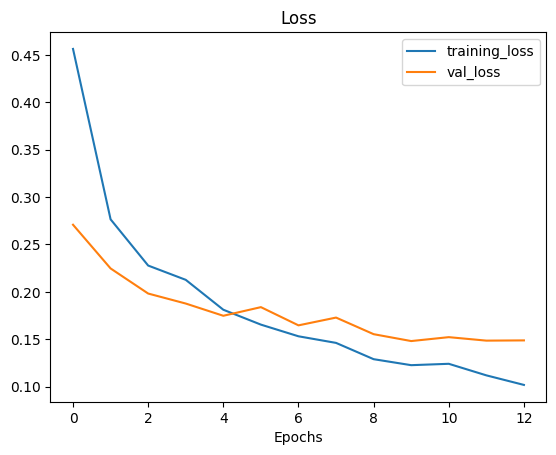

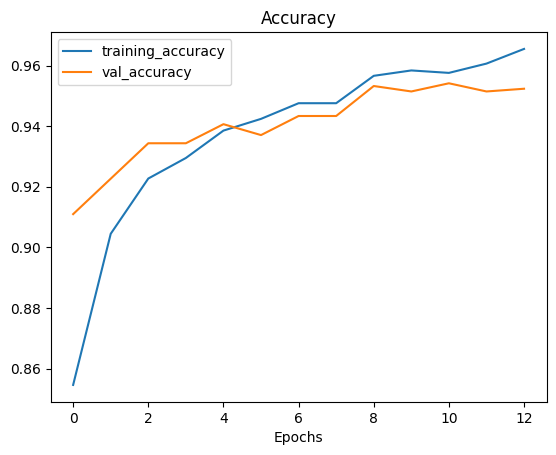

In [60]:
plot_loss_curves(EfficientNetV2S_history)

The learning curves look a little jumpy, but the dynamics look pretty good, there is a decrease in learning losses and an increase in testing accuracy.

# Model Evaluation

We use a set of test data to evaluate the accuracy of the model on new data

In [61]:
test_loss, test_accuracy = EfficientNetV2S_model.evaluate(test_data, verbose=0)

In [62]:
print("Test Loss: {:.5f}".format(test_loss))
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))

Test Loss: 0.15645
Test Accuracy: 94.83%


Given the limited data set, we obtained a good accuracy of 97%.

Let's look at the main classification metrics

In [63]:
pred_probs = EfficientNetV2S_model.predict(test_data, verbose=1)

36/36 ━━━━━━━━━━━━━━━━━━━━ 31s 657ms/step


In [64]:
pred_classes = pred_probs.argmax(axis=1)
pred_classes[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [65]:
y_labels = []
for images, labels in test_data.unbatch(): 
    y_labels.append(labels.numpy().argmax()) 
y_labels[:10] 

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Since the images in the test dataset were not shuffled, all the output labels correspond to the same class.

In [66]:
print('Classification Report \n')
target_names = class_names
print(classification_report(y_labels, pred_classes, target_names=target_names))

Classification Report 

              precision    recall  f1-score   support

  biological       0.96      0.97      0.96        99
   cardboard       0.95      0.97      0.96       182
       glass       0.97      0.93      0.95       305
       metal       0.93      0.97      0.95       100
       paper       0.96      0.92      0.94       165
     plastic       0.92      0.93      0.93       192
       trash       0.91      1.00      0.95        78

    accuracy                           0.95      1121
   macro avg       0.94      0.96      0.95      1121
weighted avg       0.95      0.95      0.95      1121



* The “Precision” column shows the percentage of correct predictions among all predictions for a particular class.
* The "Recall" column shows the percentage of images of a particular class that were predicted by the model to belong to that class.
* Column “F1” shows what percentage of model predictions were correct.
* The "Support" column shows how many images of each class were in the test dataset.

From the summary of metrics it is clear that the model classifies plastic worst of all, and best of all - things and various biological waste. However, despite the small data set, the model shows excellent performance in terms of Precision, Recall and F1 scores.

We visualize the error matrix to clearly see the correctness of class definitions

In [67]:
import itertools

In [68]:
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm = np.around(cm, decimals=2)
    cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

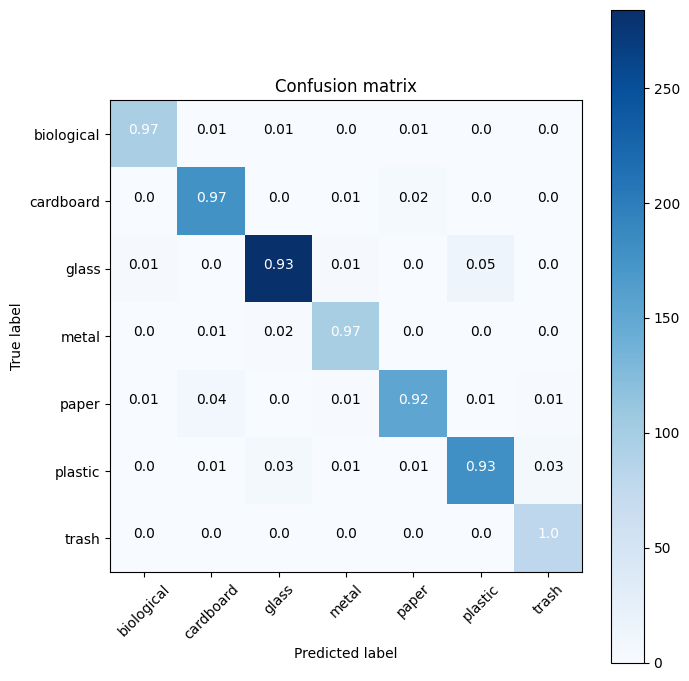

In [69]:
cm = confusion_matrix(y_labels, pred_classes)
plot_confusion_matrix(cm, class_names)

The rows of the matrix are responsible for the class predicted by the model, and the columns are for the actual class. From the error matrix, it is noticeable that in general the model’s errors are very small, although it sometimes incorrectly predicts categories, for example, it confuses plastic and glass.

Visualizing several model predictions

In [70]:
def pred_random_images(model_name, folder_path, class_names):
    plt.figure(figsize=(17, 10))
    for i in range(3):
        class_name = random.choice(class_names)
        filename = random.choice(os.listdir(folder_path + "/" + class_name))
        filepath = folder_path + "/" + class_name + "/" + filename
    
        img = tf.io.read_file(filepath)
        img = tf.image.decode_jpeg(img)
        img = tf.image.resize(img, [IMG_SIZE[0], IMG_SIZE[1]])
     #  img = img/255.
        if i == 1:
            deploy_model_emission_tracker = EmissionsTracker()
            deploy_model_emission_tracker.start()
            pred_prob = model_name.predict(tf.expand_dims(img, axis=0), verbose=0)
            deploy_model_emissions: float = prepare_data_emission_tracker.stop()
            print(f"Deploy Model Carbon Emissions: {deploy_model_emissions} kg")
        else:
            pred_prob = model_name.predict(tf.expand_dims(img, axis=0), verbose=0)
            pred_class = class_names[pred_prob.argmax()]

  # Plot the image(s)
        plt.subplot(1, 3, i+1)
        plt.imshow(img/255.)
        if class_name == pred_class: 
            title_color = "g"
        else:
            title_color = "r"
        plt.title(f"Class: {class_name},\n Pred: {pred_class},\n Prob: {pred_prob.max():.2f}", c=title_color)
        plt.axis(False);

[codecarbon WARNING @ 01:30:51] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 01:30:51] [setup] RAM Tracking...
[codecarbon INFO @ 01:30:51] [setup] CPU Tracking...
[codecarbon WARNING @ 01:30:52] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 01:30:52] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 01:30:52] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon WARNING @ 01:30:52] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 01:30:52] [setup] GPU Tracking...
[codecarbon INFO @ 01:30:52] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 01:30:52] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation mode

Deploy Model Carbon Emissions: 0.02043202013189916 kg


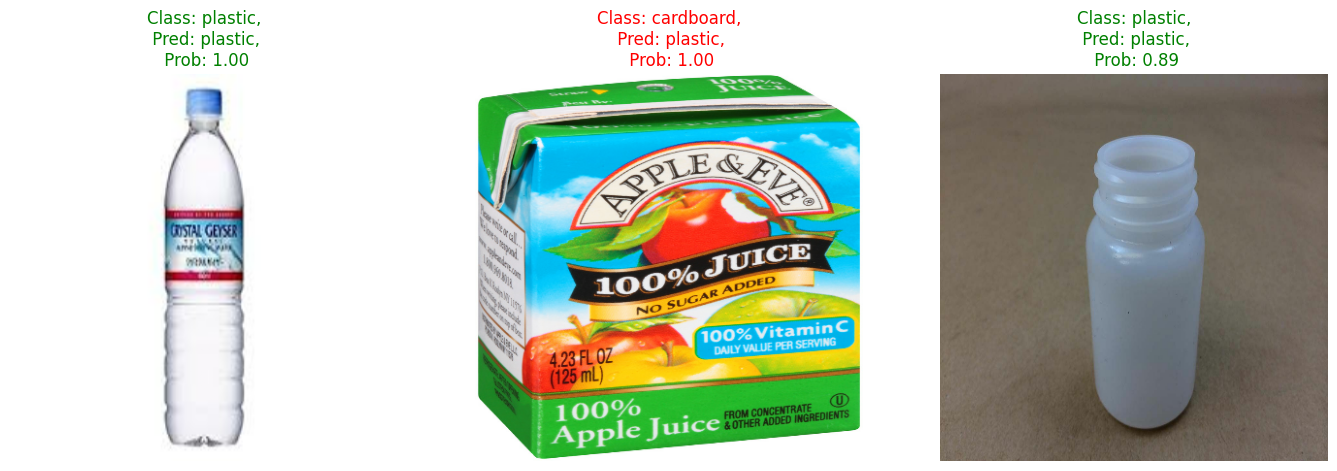

In [71]:
pred_random_images(EfficientNetV2S_model, test_path, class_names)

In [72]:
import pickle
pickle.dump(EfficientNetV2S_model,open("EfficientNetV2S_model.h5","wb"))
# EfficientNetV2S_model.save('EfficientNetV2S_model.h5')

In [73]:
ls ../working

data/                     emissions.csv              logs.zip
EfficientNetV2S.h5        garbage-classification.h5  __notebook__.ipynb
EfficientNetV2S_model.h5  logs/                      runs/
